### Introdução

O objetivo deste projeto é identificar as alavancas de venda de uma loja virtual e a partir da análise feita sugerir mudanças que aumentem o lucro.

### Importação das bibliotecas

In [1]:
import sqlalchemy as db
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engine = create_engine('sqlite:///dsci_test.sqlite')

In [3]:
itens=pd.read_sql('select * from itens', engine)

In [4]:
transacoes=pd.read_sql('select * from transacoes', engine)

In [5]:
pedidos=pd.read_sql('select * from pedidos', engine)

#### Checagem dos dados após a importação

In [6]:
itens.head()

,codigo_produto_mask,setor,familia,subfamilia,peso_unitario
0,66947358462228cf9b31cafc6368174f,Alimentos,Cachorros,Bifinhos,0.520
1,97f1357808314f0979f32f06c1b02e01,Medicina e Bem Estar,Cachorros,Vitaminas e Suplementos,0.050
2,5a4a1c97b398d291f11aeeb178f05862,Brinquedos,Cachorros,Objetos,0.073
3,321bbe12a625bf8217baa30ffdd2fc7b,Medicina e Bem Estar,Cachorros,Antipulgas e Carrapatos,0.100
4,8c65837857523fe7d4faf12c2c4c04ae,Alimentos,Cachorros,Ração Úmida,0.100


In [7]:
pedidos.head()

,id_pedido_mask,pedido_assinatura,contagempedidos,canal_venda,subcanal_venda,canal_marketing,forma_pagamento,parcelas
0,c5c58805a8d84c9de5b43644f83406c9,0,1,15bbb9d0bbf25e8d2978de1168c749dc,532c28d5412dd75bf975fb951c740a30,47a6f6bcb1457a3123e24eada0ca981f,Cartão de Crédito Total,3
1,cf66924d6e2d3ee59d23687ffbf6503a,0,5,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,6e9790f4d0acd2721e0b370023de531d,Cartão de Crédito Total,2
2,fc955ecdb43129249918f7df5bb30fa2,0,8,15bbb9d0bbf25e8d2978de1168c749dc,532c28d5412dd75bf975fb951c740a30,eb6945d3ad790ec60e20c6c85a54e30b,Boleto,1
3,38b5b3fed9097a193006d6d9acde05ed,1,13,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,2
4,00c6dca9fbed874f07b97b6211e73094,0,6,15bbb9d0bbf25e8d2978de1168c749dc,532c28d5412dd75bf975fb951c740a30,5577d244b0e0f090fb16401226bfd8e4,Cartão de Crédito Total,2


In [8]:
transacoes.head()

,id_pedido_mask,id_usuario_mask,codigo_produto_mask,quantidade,receita,frete,desconto,brinde
0,1b36ebea2c986781b5a7500b7d8971a5,57c9bb7ce32a4629b791c11f113f4e08,b56aa30a87fa7812daa689886060c0b9,1,33.66,0.00,3.74,0
1,e303a604a1d1cd5b7455dcaf256da2ec,e99abed19b0ede9a1768de5af9573a70,9322504cb6521dddcf8fcca18810c975,1,0.00,0.00,99.90,1
2,830172ec53b00a9feeefce2465eafe4c,309ba5b53dce34cac24a37b196e51c76,cca7873258ccf037fee3ee6077a67a97,1,269.09,0.00,29.90,0
3,a46ca254a2cf132f8c2087e825cc46e4,8e3428b0da37721f59d06b648fdb1d69,db69799b4b02e6d708fdf6408b400a0e,1,161.50,0.00,0.00,0
4,00627c9841286f7a2054a6b3b54d05dd,874af7ab886dd5ad7c8306d0c2f6ac83,97f1357808314f0979f32f06c1b02e01,1,41.37,0.96,4.49,0


#### Manipulação das tabelas

O primeiro objetivo desta etapa é montar um dataframe com todas as informações das tabelas importadas, sem agrupamento. 
O segundo é obter um dataframe que agrupe as variáveis id_pedido_mask e id_usuario_mask e que contenha as informações das variáveis númericas do problema. 


In [9]:
query ="""  select * from transacoes t 
            left join pedidos p on p.id_pedido_mask=t.id_pedido_mask 
            left join itens i on i.codigo_produto_mask=t.codigo_produto_mask"""
df = pd.read_sql_query(query, engine)

In [10]:
#Remover as colunas duplicadas
df = df.loc[:,~df.columns.duplicated()]

In [11]:
#Colunas que não sao do tipo int
df.select_dtypes(exclude=['int64','float64']).columns

Index(['id_pedido_mask', 'id_usuario_mask', 'codigo_produto_mask',
       'contagempedidos', 'canal_venda', 'subcanal_venda', 'canal_marketing',
       'forma_pagamento', 'parcelas', 'setor', 'familia', 'subfamilia'],
      dtype='object')

In [12]:
# Transformar as colunas parcelas em category e contagempedidos em int.
#para isso temos que converter valores vazios '' em 0:

df['parcelas']=df['parcelas'].replace('',0).astype('category')
df['contagempedidos']=df['contagempedidos'].replace('',0).astype('int64')

In [13]:
dados_gerais=df.copy() # Chamaremos este dataframe de "dados_gerais"

dados_gerais

,id_pedido_mask,id_usuario_mask,codigo_produto_mask,quantidade,receita,frete,desconto,brinde,pedido_assinatura,contagempedidos,canal_venda,subcanal_venda,canal_marketing,forma_pagamento,parcelas,setor,familia,subfamilia,peso_unitario
0,1b36ebea2c986781b5a7500b7d8971a5,57c9bb7ce32a4629b791c11f113f4e08,b56aa30a87fa7812daa689886060c0b9,1,33.66,0.00,3.74,0,0,11,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,49eba8ad9e29ac920edd33447511aaba,Cartão de Crédito Total,3,Alimentos,Gatos,Ração Seca,3.050
1,e303a604a1d1cd5b7455dcaf256da2ec,e99abed19b0ede9a1768de5af9573a70,9322504cb6521dddcf8fcca18810c975,1,0.00,0.00,99.90,1,1,2,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,3,Não Vendável,Private Label,Brinde,0.880
2,830172ec53b00a9feeefce2465eafe4c,309ba5b53dce34cac24a37b196e51c76,cca7873258ccf037fee3ee6077a67a97,1,269.09,0.00,29.90,0,1,19,a564de63c2d0da68cf47586ee05984d7,c0260a0d134bb52c3126d0e564fe718e,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,2,Alimentos,Cachorros,Ração Medicamentosa,10.240
3,a46ca254a2cf132f8c2087e825cc46e4,8e3428b0da37721f59d06b648fdb1d69,db69799b4b02e6d708fdf6408b400a0e,1,161.50,0.00,0.00,0,0,9,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,eb6945d3ad790ec60e20c6c85a54e30b,Cartão de Crédito Total,3,Medicina e Bem Estar,Cachorros,Antipulgas e Carrapatos,0.030
4,00627c9841286f7a2054a6b3b54d05dd,874af7ab886dd5ad7c8306d0c2f6ac83,97f1357808314f0979f32f06c1b02e01,1,41.37,0.96,4.49,0,0,5,87d17f4624a514e81dc7c8e016a7405c,1bdf605991920db11cbdf8508204c4eb,6e9790f4d0acd2721e0b370023de531d,,0,Medicina e Bem Estar,Cachorros,Vitaminas e Suplementos,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220582,95920cddbcd4f4913ffce26b8ca49dfa,976d163009b94bb9275a9e460ac79f90,820bd13bf875566ca4c39779f45325b2,1,25.26,0.36,0.00,0,0,8,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,bd9a2916f0e054a9361a98a97b8db5dc,Boleto,1,Brinquedos,Cachorros,Pelúcia,0.045
220583,ff2939d16cff9201ff8f5a98ffe410f0,136e521b9ae07b7031d1bc82cb19c1bf,67db5dce5456a4a1d46fb460a8128766,1,94.40,0.00,10.50,0,1,10,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,3,Alimentos,Cachorros,Ração Seca,15.200
220584,1743a74b4ba30c8a1f6517072898dd35,e26284380c55fd5928c1b37add47baa9,34ec52470cd276429e7ddf82b8f7e6d4,1,10.79,0.00,1.20,0,1,6,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,3,Alimentos,Cachorros,"Petiscos, Biscoitos e Snacks",0.580
220585,87fad7ea78a2f16cac8e87f622e2cbb4,477117715d786f8d66a77174dc67e41b,082036652b8f8e975cd350bf7eb7bf96,1,0.00,0.00,89.90,1,1,7,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,1,Não Vendável,Ac. Pet Lovers,Brinde,0.250


In [14]:
# O segundo dataframe irá agrupar as variávias id_pedido_mask e id_usuario_mask.
# Desta forma, não teremos nenhuma linha com valores de número de pedido duplicadas.

query2 =""" select t.id_pedido_mask, t.id_usuario_mask, p.pedido_assinatura, SUM(t.receita) receita, 
            SUM(t.brinde) brinde,MAX(p.contagempedidos) contagempedidos,SUM(t.frete) frete, 
            SUM(i.peso_unitario) peso_pedido, SUM(t.quantidade) quantidade, SUM(t.desconto) desconto,
            p.parcelas, p.canal_venda, p.subcanal_venda,p.canal_marketing,p.forma_pagamento,
            case when MAX(p.contagempedidos)<=15 then 'regular'
                 when MAX(p.contagempedidos)>= 36 then 'vip' 
                 else 'fiel'end as tipocliente

            from transacoes t left join pedidos p on p.id_pedido_mask=t.id_pedido_mask 
            left join itens i on i.codigo_produto_mask=t.codigo_produto_mask 
            group by t.id_pedido_mask,t.id_usuario_mask,p.pedido_assinatura,p.parcelas,p.canal_venda,
            p.subcanal_venda,p.canal_marketing,p.forma_pagamento """
df1 = pd.read_sql_query(query2, engine)
df1 = pd.read_sql_query(query2, engine)
df1['contagempedidos']=df1['contagempedidos'].replace('',0).astype('int64')
df1['parcelas']=df1['parcelas'].replace('',0).astype('category')
dados_agrupados=df1.copy()
dados_agrupados.head()

,id_pedido_mask,id_usuario_mask,pedido_assinatura,receita,brinde,contagempedidos,frete,peso_pedido,quantidade,desconto,parcelas,canal_venda,subcanal_venda,canal_marketing,forma_pagamento,tipocliente
0,0000b0f8dd3cc7c5058fb8307a252227,a1aa3c5157fbb01ccd7960415e971fe4,0,127.74,0,18,0.0,16.810,3,0.00,3,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,9db6d32a7901332471c3d304cf0a9a58,Cartão de Crédito Total,fiel
1,0005dc868fdc729a89aff2919c59eac3,8e6e06a58f303366beafb4b5ad924118,1,385.56,1,35,0.0,23.185,7,42.85,3,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,fiel
2,0006e6e7915720a25ac4c11456f43296,3d23f45ea3a4391225eea48a4458828e,0,311.71,1,12,0.0,31.220,10,34.64,3,15bbb9d0bbf25e8d2978de1168c749dc,b2c79ad7dcf03ba266dc0885e1266675,49eba8ad9e29ac920edd33447511aaba,Cartão de Crédito Total,regular
3,0008599eb84d4b6e804eff6512eabec1,ec2ac1ce9d41301210075bf96c383c63,1,274.38,0,6,0.0,32.980,6,30.49,1,a564de63c2d0da68cf47586ee05984d7,6ab241effd5d8dd6ecdd79cba1ac174a,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,regular
4,00098d84b5c5f0faa8ed2501384f7809,0ed0959dc3166cd6c6e6ab6a36151566,1,368.51,1,39,0.0,4.415,5,40.96,3,a564de63c2d0da68cf47586ee05984d7,9ddad75add037114e04fd4e0b96e0642,decc1eab6d0751fcb2d8e41a2ffeb55a,Cartão de Crédito Total,vip


### Análise geral dos dados

Inicialmente, vamos explorar os dados de forma geral.   
Nesta etapa utilizaremos o dataframe dados_gerais para investigar as variáveis categóricas em função da receita.

Text(0, 0.5, 'Setor')

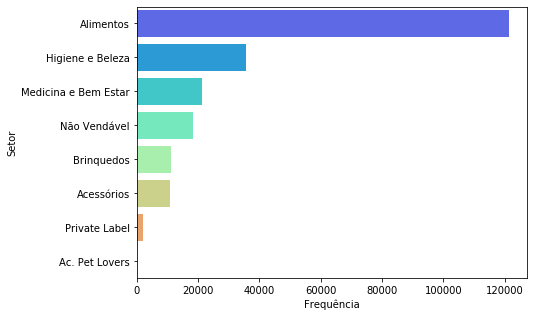

In [15]:
# Ranking dos setores que mais geram receitas
plt.figure(figsize=(7,5))
sns.countplot(y='setor', data=dados_gerais,
              order = dados_gerais['setor'].value_counts().index,palette="rainbow")
plt.xlabel('Frequência')
plt.ylabel('Setor')

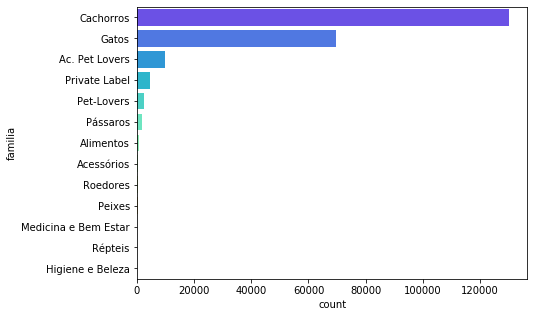

In [16]:
# Ranking das famílias que mais geram receitas
plt.figure(figsize=(7,5))
sns.countplot(y='familia', data=dados_gerais,
              order = dados_gerais['familia'].value_counts().index,palette="rainbow")

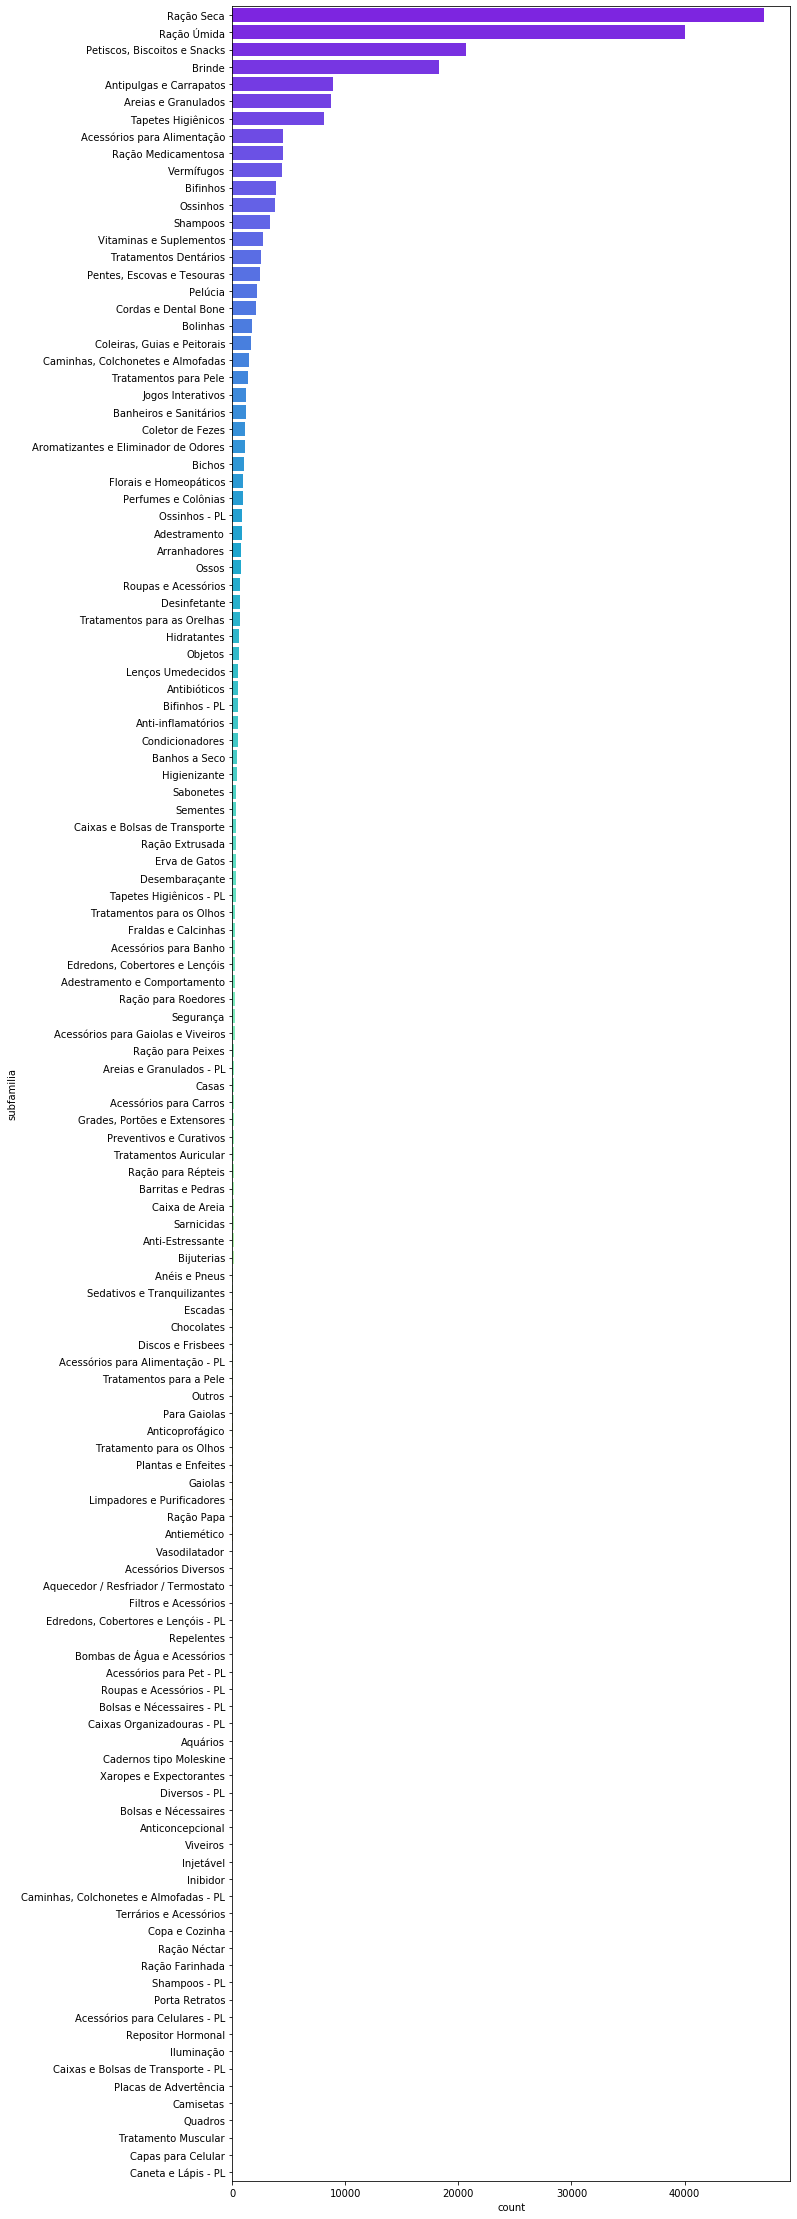

In [17]:
# Ranking das subfamílias que mais geram receitas
plt.figure(figsize=(10,40))
sns.countplot(y='subfamilia', data=dados_gerais,
              order = dados_gerais['subfamilia'].value_counts().index,palette="rainbow")

Os gráficos acima não mostram de forma clara e objetiva os principais setores, famílias e subfamílias que mais geram receita. Portanto, para facilitar a visualização, faremos um pie chart contendo apenas as principais categorias.

In [18]:
vendas_setor=dados_gerais.groupby('setor').sum()[['receita']].reset_index()
vendas_setor['receita%']=vendas_setor['receita']/vendas_setor['receita'].sum()*100
vendas_setor=vendas_setor.sort_values(by='receita%',ascending=False).reset_index(drop=True)
vendas_setor=vendas_setor.nlargest(5, "receita%")


vendas_familia=dados_gerais.groupby('familia').sum()[['receita']].reset_index()
vendas_familia['receita%']=vendas_familia['receita']/vendas_familia['receita'].sum()*100
vendas_familia=vendas_familia.sort_values(by='receita%',ascending=False).reset_index(drop=True)
vendas_familia=vendas_familia.nlargest(5, "receita%")

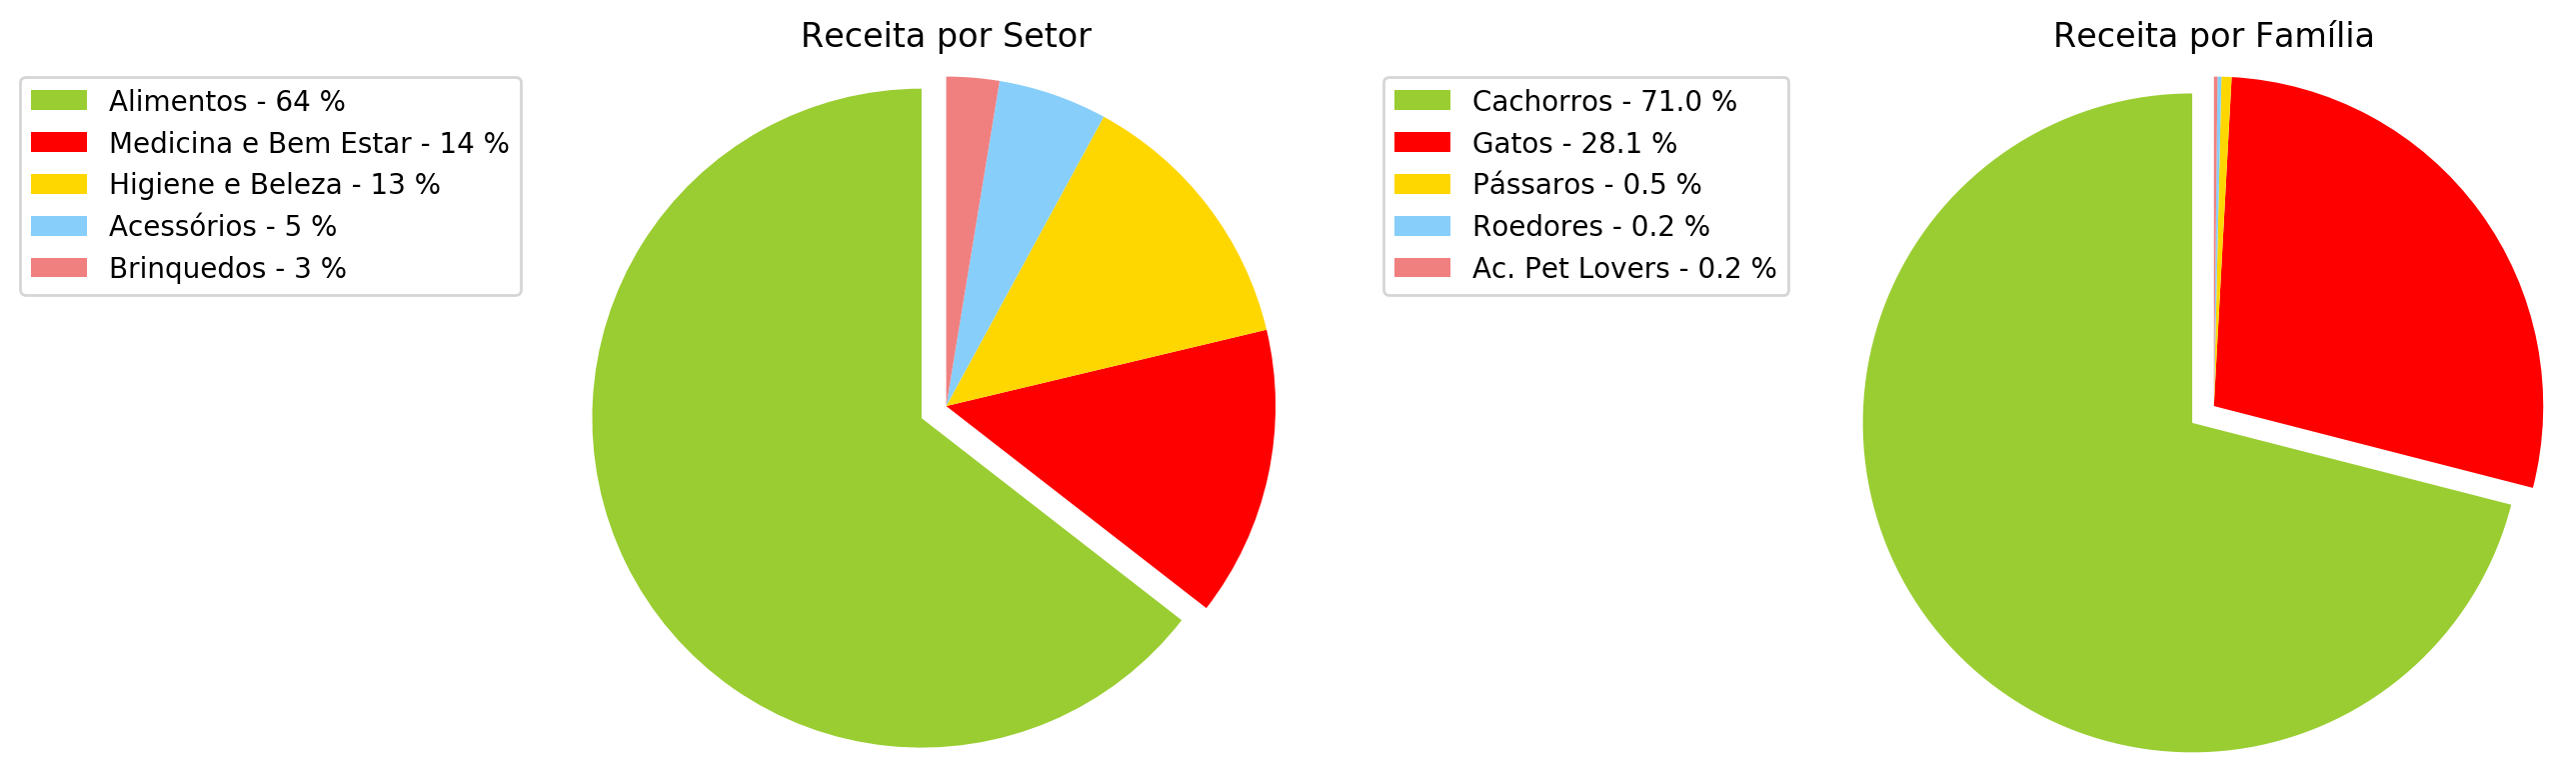

In [19]:
fig = plt.figure(figsize=(15,10), dpi=200)
#2 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,2),(0,0))
x = vendas_setor['setor']
y = vendas_setor['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode =explode )
labels = ['{0} - {1:1.0f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

plt.title('Receita por Setor')
#first row sec col
ax1 = plt.subplot2grid((2,2), (0, 1))
x = vendas_familia['familia']
y = vendas_familia['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode =explode)
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.title('Receita por Família')
plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)



Os setores que mais vendem na empresa são Alimentos, Medicina e Bem Estar e Higiene e Beleza; estes grupos representam 91% da receita total.
Dentro das categorias das famílias, os produtos para Cachorros e Gatos concentram 99,1% da receita total.

### Subfamílias que mais contribuem com a receita da empresa

In [20]:
# Verificar os diferentes tipos de família 
cols_familia=dados_gerais['familia'].unique()
cols_familia

# Criar um dicionário para alocar os valores de venda e porcentagem de venda das subfamílias referentes a cada tipo diferente de familia  
subfamilias={}
for col in cols_familia:
    subfamilias["subfamilia{0}".format(col.replace(' ', ''))] = []
    
for subfamilia, col in zip(subfamilias,cols_familia):
    subfamilias[subfamilia]=dados_gerais[dados_gerais['familia'].str.contains(col)]
    subfamilias[subfamilia]=subfamilias[subfamilia].groupby('subfamilia').sum()[['receita']].reset_index()
    subfamilias[subfamilia]['receita%']=subfamilias[subfamilia]['receita']/subfamilias[subfamilia]['receita'].sum()*100
    subfamilias[subfamilia]=subfamilias[subfamilia].sort_values(by='receita%',ascending=False).reset_index(drop=True)
    subfamilias[subfamilia]=subfamilias[subfamilia].nlargest(5,'receita%')
    

Text(0.5, 1.0, 'Gatos')

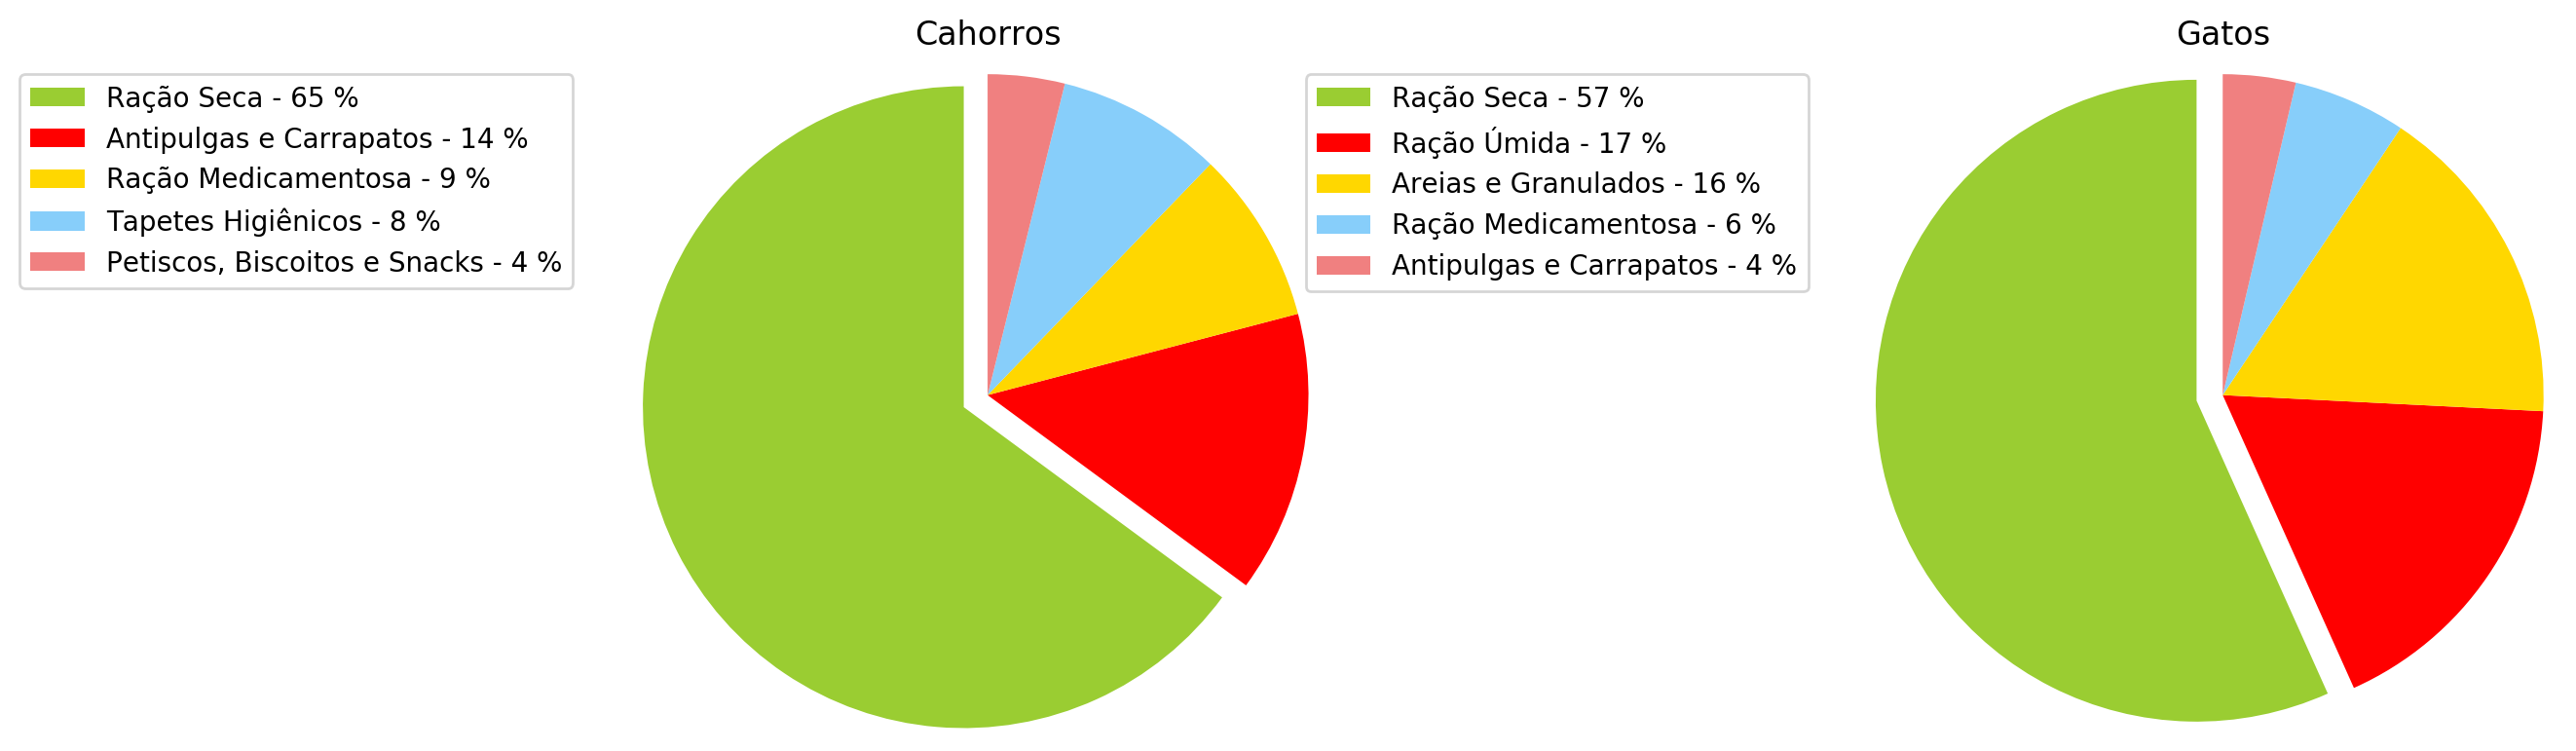

In [21]:
fig = plt.figure(figsize=(15,10), dpi=200)
#2 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,2),(0,0))
x = subfamilias['subfamiliaCachorros']['subfamilia']
y = subfamilias['subfamiliaCachorros']['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode=explode)
labels = ['{0} - {1:1.0f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

plt.title('Cahorros')
#first row sec col
ax1 = plt.subplot2grid((2,2), (0, 1))
x = subfamilias['subfamiliaGatos']['subfamilia']
y = subfamilias['subfamiliaGatos']['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode=explode)
labels = ['{0} - {1:1.0f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)
plt.title('Gatos')


Ao analisar as subfamílias dos Cachorros e Gatos, vemos que os produtos mais vendidos são das categorias Ração, Ração úmida, Antipulgas, etc; produtos que se encontram nas categorias dos setores mais vendidos.

### Receita por canal e subcal de vendas

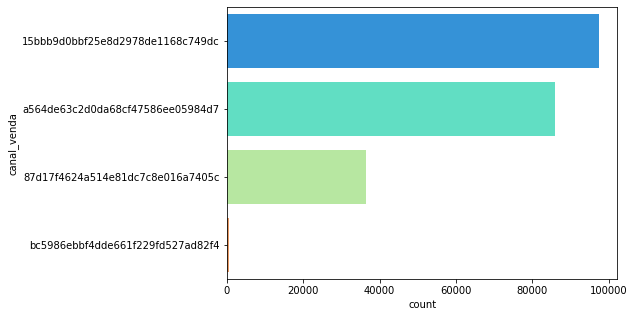

In [22]:
plt.figure(figsize=(7,5))
sns.countplot(y='canal_venda', data=dados_gerais,
              order = dados_gerais['canal_venda'].value_counts().index,palette="rainbow")

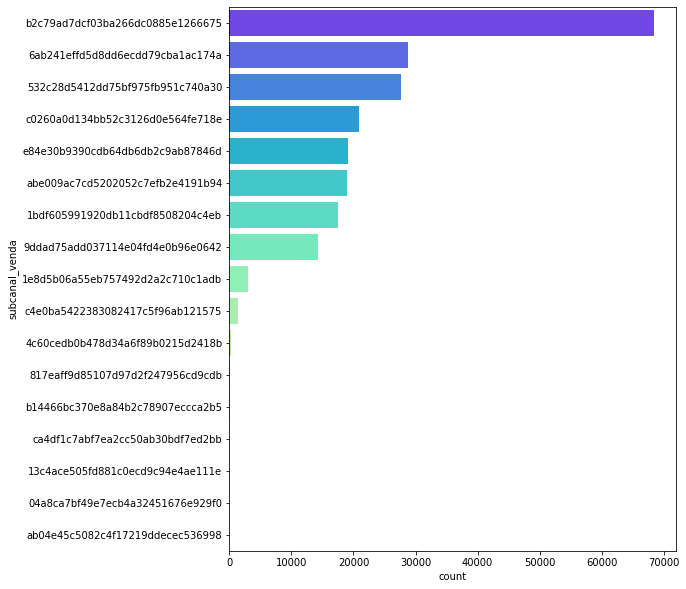

In [23]:
plt.figure(figsize=(8,10))
sns.countplot(y='subcanal_venda', data=dados_gerais,
              order = dados_gerais['subcanal_venda'].value_counts().index,palette="rainbow")

Iremos novamente mostrar as principais categorias em pie charts para facilitar a visualização.

In [24]:
vendas_canal=dados_gerais.groupby('canal_venda').sum()[['receita']].reset_index()
vendas_canal['receita%']=vendas_canal['receita']/vendas_canal['receita'].sum()*100
vendas_canal=vendas_canal.sort_values(by='receita%',ascending=False).reset_index(drop=True)


vendas_subcanal=dados_gerais.groupby('subcanal_venda').sum()[['receita']].reset_index()
vendas_subcanal['receita%']=vendas_subcanal['receita']/vendas_subcanal['receita'].sum()*100
vendas_subcanal=vendas_subcanal.sort_values(by='receita%',ascending=False).reset_index(drop=True)
vendas_subcanal=vendas_subcanal.nlargest(8, "receita%")

Text(0.5, 1.0, 'Receita por Canal')

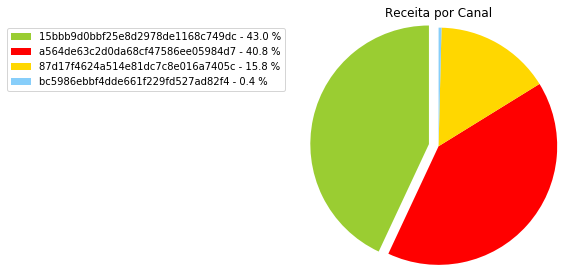

In [25]:
fig = plt.figure(figsize=(15,10))
#2 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,2),(0,0))
x = vendas_canal['canal_venda']
y = vendas_canal['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode =explode )
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)

plt.title('Receita por Canal')



Text(0.5, 1.0, 'Receita por Subcanal')

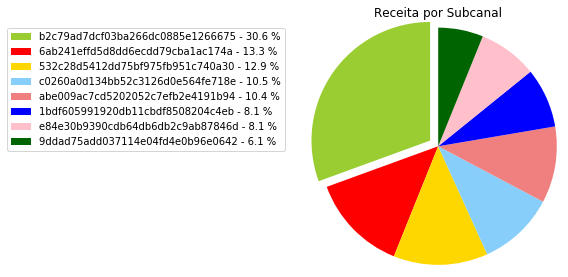

In [26]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0, 1))
x = vendas_subcanal['subcanal_venda']
y = vendas_subcanal['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode =explode)
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)
plt.title('Receita por Subcanal')


A porcentagem da receita por canais de venda é concentrada em 95% em três canais de venda. Já os subcanais de venda apresentam a porcentagem da receita mais homogênea, como pode ser observado acima.  

### Receita por canal de marketing

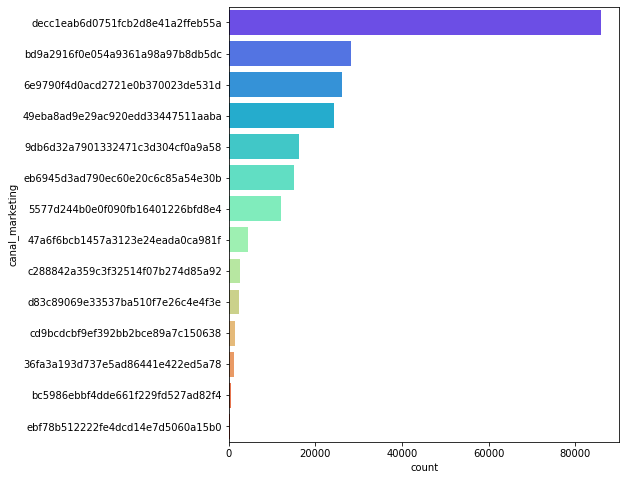

In [27]:
plt.figure(figsize=(7,8))
sns.countplot(y='canal_marketing', data=dados_gerais,
              order = dados_gerais['canal_marketing'].value_counts().index,palette="rainbow")

Iremos novamente mostrar as principais categorias em pie charts para facilitar a visualização.

In [28]:
vendas_marketing=dados_gerais.groupby('canal_marketing').sum()[['receita']].reset_index()
vendas_marketing['receita%']=vendas_marketing['receita']/vendas_marketing['receita'].sum()*100
vendas_marketing=vendas_marketing.sort_values(by='receita%',ascending=False).reset_index(drop=True)
vendas_marketing=vendas_marketing.nlargest(10, "receita%")

Text(0.5, 1.0, 'Receita por Canal de Marketing')

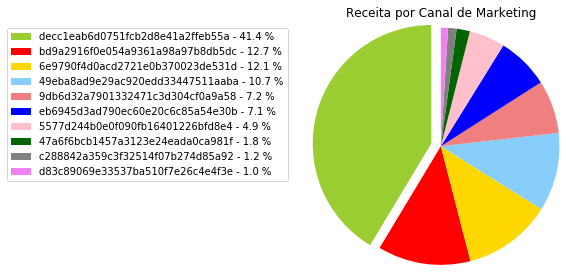

In [29]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0, 1))
x = vendas_marketing['canal_marketing']
y = vendas_marketing['receita%']
colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()
explode =(0.1,0,0,0,0,0,0,0,0,0) 
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode=explode)
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.),
           fontsize=10)
plt.title('Receita por Canal de Marketing')


Os canais de marketing apresentam uma distribuição relativamente homogênea na porcentagem de receita, com exceção de um que concentra 40% da receita.

### Análise das variáveis numéricas

Nesta parte da análise iremos utilizar o dataframe dados_agrupados.

In [30]:
# Antes de iniciar a exploração dos dados, podemos ver uma descrição estatística dos dados.
# Aqui já observamos que algumas variáveis possuem outliers.
dados_agrupados.describe()

,pedido_assinatura,receita,brinde,contagempedidos,frete,peso_pedido,quantidade,desconto
count,44012.000000,44012.000000,44012.000000,44012.000000,44012.000000,44012.000000,44012.000000,44012.000000
mean,0.380669,299.152423,0.604971,13.059620,4.239001,13.771060,11.781151,47.448774
std,0.485557,208.214057,0.855570,20.140435,11.055905,13.499296,21.971400,72.477478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.008000,1.000000,0.000000
25%,0.000000,167.767500,0.000000,2.000000,0.000000,3.230000,3.000000,0.010000
50%,0.000000,280.430000,0.000000,6.000000,0.000000,10.694500,5.000000,25.440000
75%,1.000000,379.600000,1.000000,16.000000,0.000000,20.046250,11.000000,69.900000
max,1.000000,7051.860000,17.000000,651.000000,417.140000,300.439000,1011.000000,5052.960000


A fim de melhor avaliar os outliers, vamos analisar os boxplots das váriaveis numéricas. 

In [31]:
numeric_variables=['quantidade', 'receita', 'frete','brinde', 'desconto','contagempedidos', 'peso_pedido','parcelas']

In [32]:
def boxplot(data, y, title):    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    sns.boxplot(y = y, data = data, ax = ax[0],color='c')
    ax[0].set_ylabel(y, fontsize = 12)
    ax[0].set_title(title, fontsize = 16)
    
    sns.boxplot(y = y, data = data, ax = ax[1],color='c')
    ax[1].set_ylabel(y, fontsize = 12)
    ax[1].set_title(title, fontsize = 16)
    ax[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

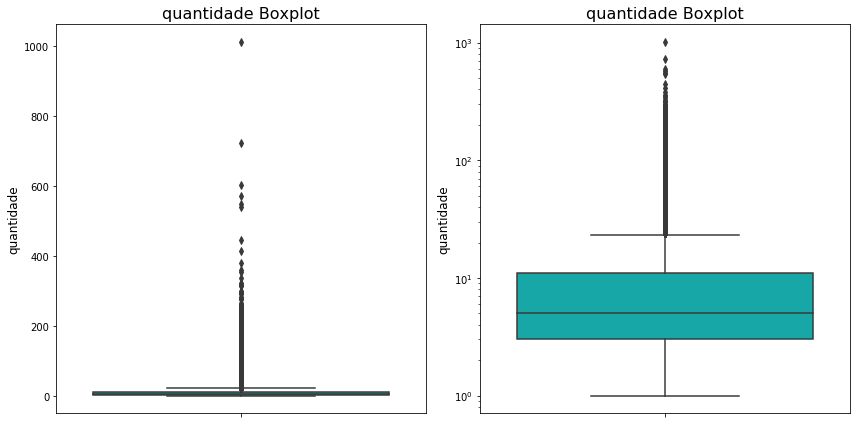

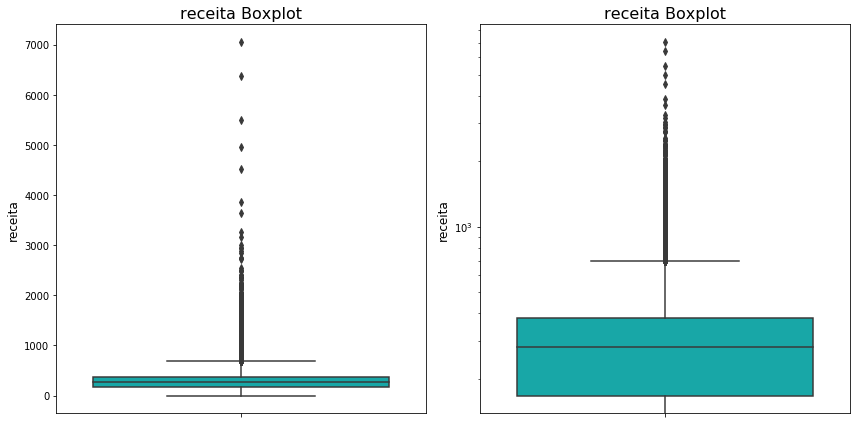

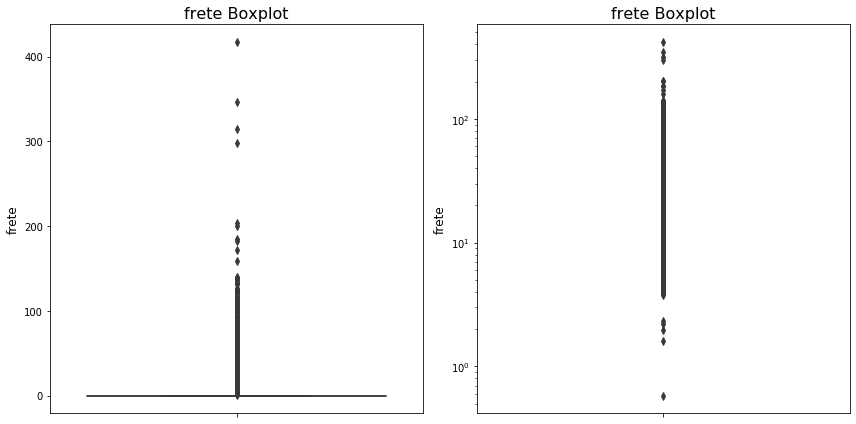

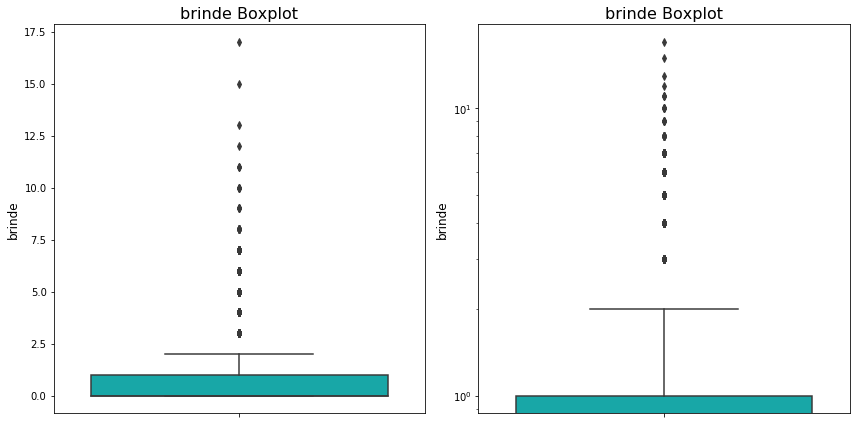

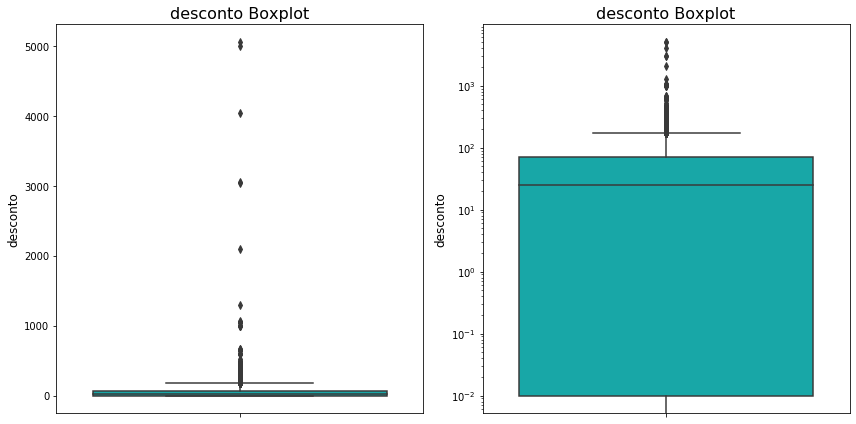

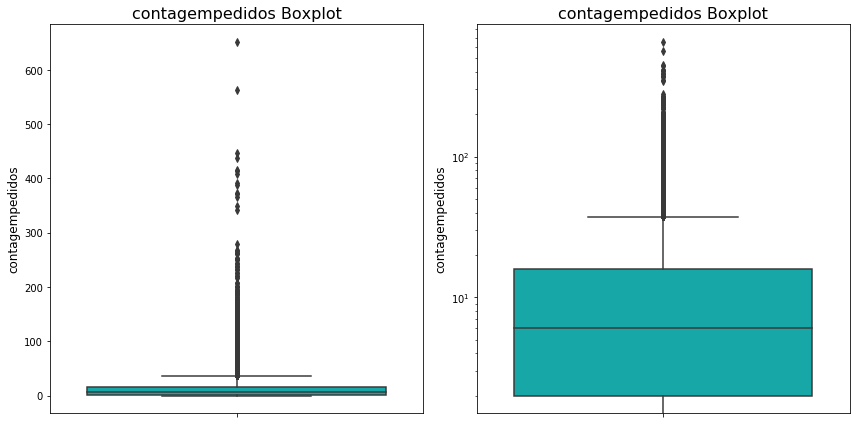

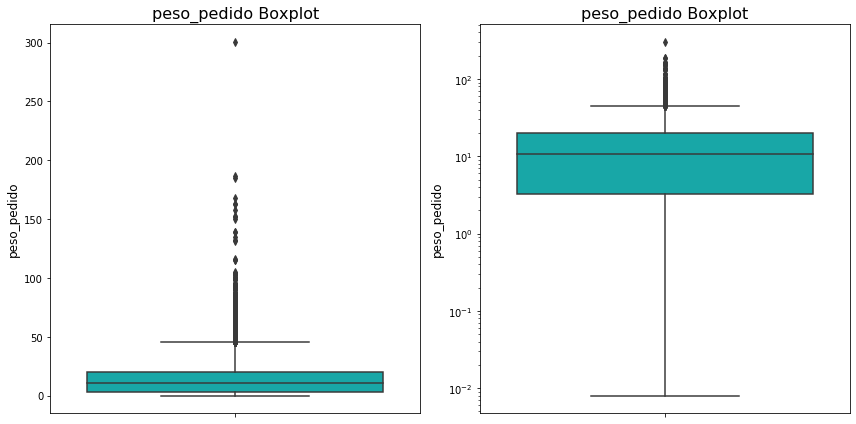

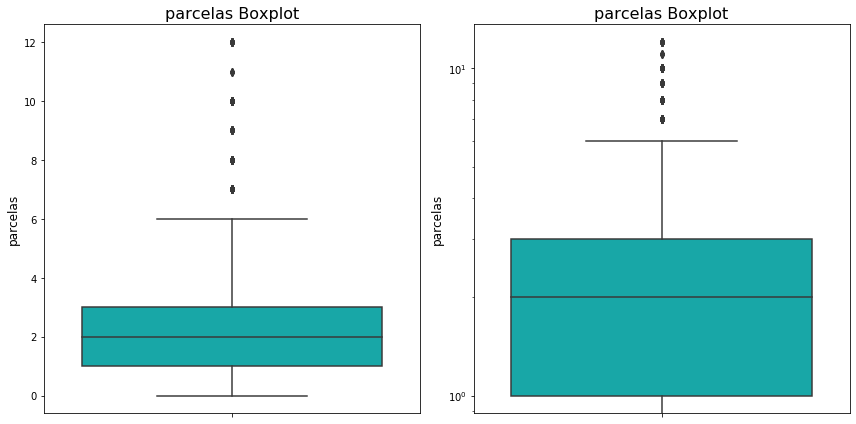

In [33]:
for x in numeric_variables:
    boxplot(data = dados_agrupados, y = x, title = x + " Boxplot")

Vamos analisar os outliars de cada variável

In [34]:
# Os valores em quantidade parecem razoáveis e não serão removidos
dados_agrupados[numeric_variables].sort_values(by = "quantidade", ascending = False).head()

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
29601,1011,1604.29,0.0,17,672.51,7,9.588,2
10612,722,1294.56,0.0,1,143.85,8,20.957,1
25314,602,918.00,0.0,2,107.11,11,0.514,1
43430,570,2511.94,0.0,3,464.80,21,36.557,3
2085,549,5492.94,0.0,2,181.78,77,30.217,1


In [35]:
# Os valores em receita parecem razoáveis e não serão removidos
dados_agrupados[numeric_variables].sort_values(by = "receita", ascending = False).head()

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
31800,103,7051.86,0.00,1,29.90,1,132.290,3
20814,353,6383.60,346.02,11,1290.35,1,184.836,1
2085,549,5492.94,0.00,2,181.78,77,30.217,1
11207,110,4953.07,0.00,1,69.90,1,89.677,3
22553,30,4510.89,0.00,1,591.11,14,16.030,1


In [36]:
# Os valores em frete parecem razoáveis e não serão removidos
dados_agrupados[numeric_variables].sort_values(by = "frete", ascending = False).head()

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
17303,20,2178.58,417.14,1,310.85,1,99.170,3
20814,353,6383.60,346.02,11,1290.35,1,184.836,1
13936,28,2073.95,314.16,3,81.08,12,61.809,3
32397,2,504.63,297.81,0,22.98,2,25.200,3
23697,22,739.59,203.69,2,598.90,9,8.550,3


In [37]:
# Os valores em deconto acima de 1000 serão removidos 
dados_agrupados[numeric_variables].sort_values(by = "desconto", ascending = False).head(20)

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
11543,12,476.49,0.00,4,5052.96,18,31.294,1
39433,11,499.05,0.00,2,5000.01,8,15.445,1
2323,11,387.43,0.00,2,4043.06,2,11.561,3
42623,21,419.04,0.00,3,3046.58,33,11.007,2
8028,17,399.33,0.00,3,3044.38,31,36.914,3
37410,9,809.55,0.00,3,2089.97,23,10.948,3
20814,353,6383.60,346.02,11,1290.35,1,184.836,1
21853,12,570.99,0.00,2,1060.42,7,57.430,4
13560,9,328.75,0.00,2,1058.02,1,20.662,2
22048,6,310.67,0.00,2,1054.83,1,26.865,3


In [38]:
dados_agrupados=dados_agrupados[dados_agrupados['desconto']<1000]

In [39]:
# Os valores em contagempedido parecem razoáveis e não serão removidos
dados_agrupados[numeric_variables].sort_values(by = "contagempedidos", ascending = False).head()

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
36364,38,201.78,0.0,0,22.42,651,0.677,1
35931,5,26.55,0.0,0,2.95,562,0.336,1
26932,1,14.31,0.0,0,1.59,447,1.100,1
5466,2,49.32,0.0,0,5.48,437,4.210,1
11488,6,341.26,0.0,1,107.82,415,9.368,1


In [40]:
# Os valores em peso_unitario parecem razoáveis e não serão removidos
dados_agrupados[numeric_variables].sort_values(by = "peso_pedido", ascending = False).head()

,quantidade,receita,frete,brinde,desconto,contagempedidos,peso_pedido,parcelas
28308,55,2730.11,0.0,1,343.25,1,300.439,1
15576,26,2404.02,0.0,0,267.11,1,186.955,3
17637,74,1769.07,0.0,1,69.90,1,167.580,1
41693,62,1865.56,0.0,4,336.99,8,162.426,1
41694,62,1865.56,0.0,4,336.99,8,162.426,3


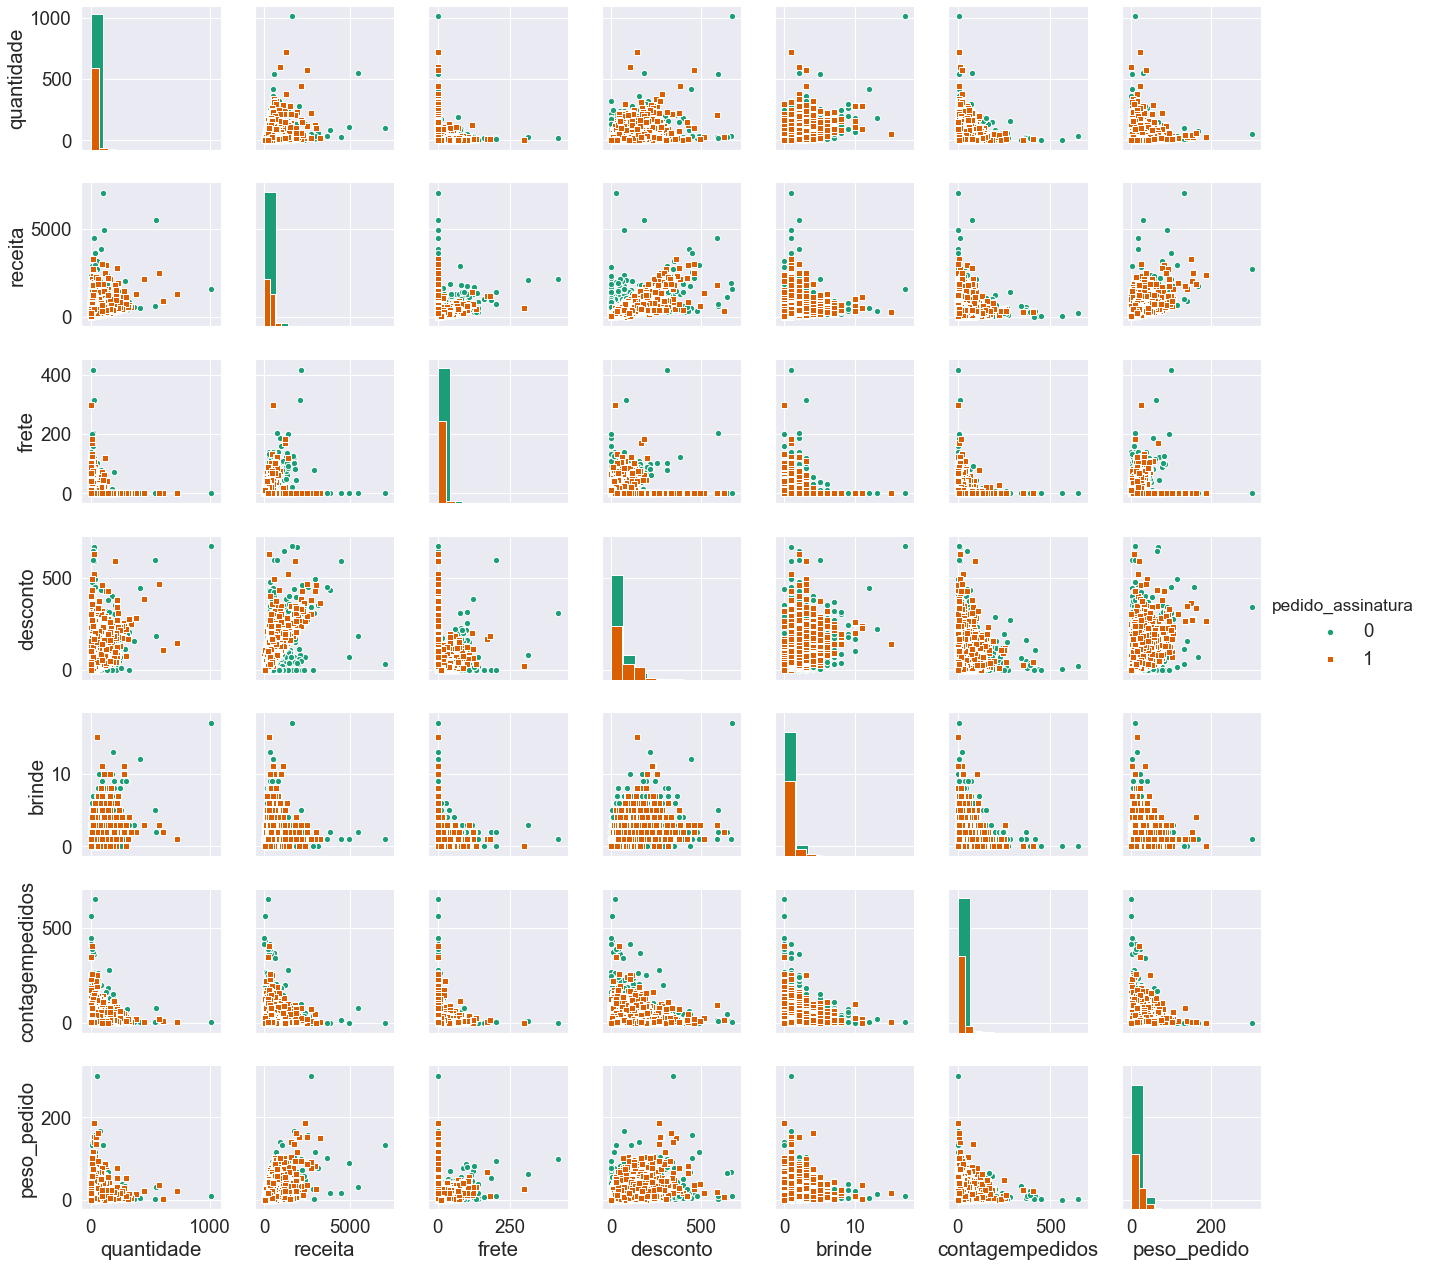

In [41]:
# Antes de prosseguir nas análises, é interessante ter um overview de como as variáveis se relacionam entre si.
# Para isso, utilizaremos o pairGrids e o correlation heatmap.
sns.set(font_scale=1.7)
g=sns.PairGrid(dados_agrupados, vars=['quantidade', 'receita', 'frete', 'desconto','brinde',
                                'contagempedidos','peso_pedido'],hue="pedido_assinatura", palette="Dark2",
                 hue_kws={"marker": ["o", "s", "D"]})
g = g.map_offdiag(plt.scatter,linewidths=1, edgecolor="w", s=40)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.add_legend()

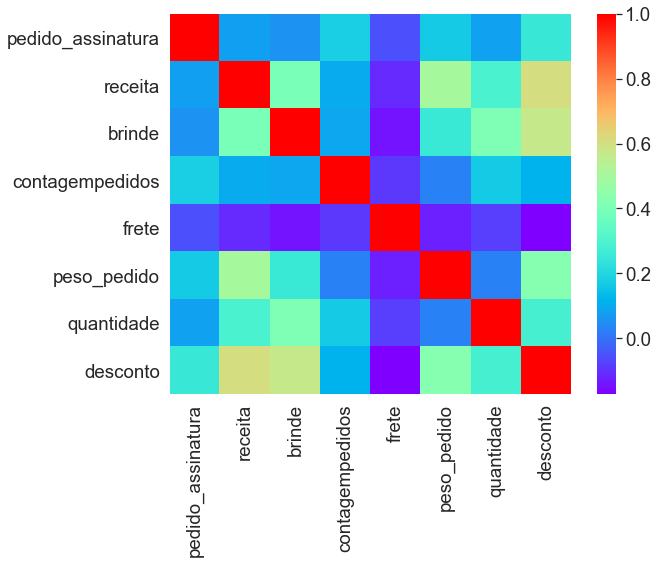

In [42]:
plt.figure(figsize=(9,7))
corr = dados_agrupados.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap='rainbow')

Pelo paigrid e heatmap, vemos que algumas variáveis estão correlacionadas. Receita e desconto, receita e peso_pedido, receita e brinde, receita e quantidade, desconto e brinde, desconto e peso_pedido e algumas outras.

### Comparação entre pedidos de assinantes e não assinantes

Nesta parte, exploraremos relação entre os dados de pedidos feitos por assinantes e não assinante da loja.

In [43]:
# Criação de uma tabela agrupada pelo id do usuário e que contém a soma da receita, 
# o número de pedidos, receita/pedido, número de pedidos/cliente, % de desconto entre pedido de assinante e não assinante 
# e se o pedido é de assinatura pet love ou não.


tabela_comparacao_assinantes=pd.DataFrame()
table1=dados_agrupados.groupby('id_usuario_mask').sum()[['receita']][1:]
table2=dados_agrupados.groupby('id_usuario_mask').max()[['contagempedidos']][1:]
table3=dados_agrupados.groupby('id_usuario_mask').mean()[['pedido_assinatura']][1:]
table4=dados_agrupados.groupby('id_usuario_mask').sum()[['desconto']][1:]

tabela_comparacao_assinantes['']=['Assinantes','Não Assinantes']
tabela_comparacao_assinantes['porcentagem']=[len(table1[table3['pedido_assinatura']==1])*100/len(table1),
                                  len(table1[table3['pedido_assinatura']==0])*100/len(table1)]
tabela_comparacao_assinantes['Receita']=[table1[table3['pedido_assinatura']==1]['receita'].sum(),
                             table1[table3['pedido_assinatura']==0]['receita'].sum()]
tabela_comparacao_assinantes['Receita%']=[table1[table3['pedido_assinatura']==1]['receita'].sum()*100/table1['receita'].sum(),
                             table1[table3['pedido_assinatura']==0]['receita'].sum()*100/table1['receita'].sum()]
tabela_comparacao_assinantes['N pedidos']=[table2[table3['pedido_assinatura']==1]['contagempedidos'].sum(),
                             table2[table3['pedido_assinatura']==0]['contagempedidos'].sum()]
tabela_comparacao_assinantes['N pedidos/cliente']=[table2[table3['pedido_assinatura']==1]['contagempedidos'].sum()/
                                        len(table1[table3['pedido_assinatura']==1]),
                             table2[table3['pedido_assinatura']==0]['contagempedidos'].sum()/
                                        len(table1[table3['pedido_assinatura']==0])]
tabela_comparacao_assinantes['desconto%']=[table4[table3['pedido_assinatura']==1]['desconto'].sum()*100/table4['desconto'].sum(),
                             table4[table3['pedido_assinatura']==0]['desconto'].sum()*100/table4['desconto'].sum()]
tabela_comparacao_assinantes['Receita/pedido']=[table1[table3['pedido_assinatura']==1]['receita'].sum()/
                                     table2[table3['pedido_assinatura']==1]['contagempedidos'].sum(),
                                     table1[table3['pedido_assinatura']==0]['receita'].sum()/
                                     table2[table3['pedido_assinatura']==0]['contagempedidos'].sum()]
round(tabela_comparacao_assinantes,2).style.hide_index()

,porcentagem,Receita,Receita%,N pedidos,N pedidos/cliente,desconto%,Receita/pedido
Assinantes,34.450000,4896002.060000,37.260000,205790,15.730000,47.720000,23.790000
Não Assinantes,63.070000,7404045.100000,56.350000,201074,8.400000,44.330000,36.820000


Os clientes assinantes, apesar de contribuir com uma porcentagem mais baixa da receita (37%), possuem a razão número de pedidos por cliente duas vezes maior do que os não assinantes. O assinantes do site concentram 47% dos descontos dados pela empresa.

### Comparação entre pedidos de assinantes e não assinantes

In [44]:
# Criação de uma tabela comparando pedidos com e sem brindes, que contém a soma da receita, 
# o número de pedidos e receita/pedido.

tabela_comparacao_brinde=pd.DataFrame()

In [45]:
tabela_comparacao_brinde['Brinde']=['Sim','Não']
tabela_comparacao_brinde['porcentagem']=[len(dados_agrupados[dados_agrupados['brinde']!=0])*100/len(dados_agrupados),
                                  len(dados_agrupados[dados_agrupados['brinde']==0])*100/len(dados_agrupados)]
tabela_comparacao_brinde['receita']=[dados_agrupados[dados_agrupados['brinde']!=0]['receita'].sum(),
                          dados_agrupados[dados_agrupados['brinde']==0]['receita'].sum()]

tabela_comparacao_brinde['receita%']=[dados_agrupados[dados_agrupados['brinde']!=0]['receita'].sum()*100/dados_agrupados['receita'].sum(),
                          dados_agrupados[dados_agrupados['brinde']==0]['receita'].sum()*100/dados_agrupados['receita'].sum()]

tabela_comparacao_brinde['N pedidos']=[len(dados_agrupados[dados_agrupados['brinde']!=0]),
                                  len(dados_agrupados[dados_agrupados['brinde']==0])]

tabela_comparacao_brinde['Receita/pedido']=[dados_agrupados[dados_agrupados['brinde']!=0]['receita'].sum()/
                                 len(dados_agrupados[dados_agrupados['brinde']!=0]),
                                  dados_agrupados[dados_agrupados['brinde']==0]['receita'].sum()/
                                 len(dados_agrupados[dados_agrupados['brinde']==0])]
round(tabela_comparacao_brinde,2).style.hide_index()

Brinde,porcentagem,receita,receita%,N pedidos,Receita/pedido
Sim,45.340000,8192232.950000,62.280000,19947,410.700000
Não,54.660000,4962096.430000,37.720000,24050,206.320000


Os pedidos que contêm brinde, representam 62% da receita e 45% dos pedidos totais. Além disso,quando o pedido contém pelo menos um brinde, a razão receita/pedido é 2x maior em relação a pedidos sem brinde.

### Comparação entre pedidos com e sem desconto

In [46]:
# Criação de uma tabela comparando pedidos com e sem brindes, que contém a soma da receita, 
# o número de pedidos e receita/pedido.

tabela_comparacao_desconto=pd.DataFrame()

In [47]:
tabela_comparacao_desconto['desconto']=['Sim','Não']
tabela_comparacao_desconto['porcentagem']=[len(dados_agrupados[dados_agrupados['desconto']!=0])*100/len(dados_agrupados),
                                  len(dados_agrupados[dados_agrupados['desconto']==0])*100/len(dados_agrupados)]
tabela_comparacao_desconto['receita']=[dados_agrupados[dados_agrupados['desconto']!=0]['receita'].sum(),
                          dados_agrupados[dados_agrupados['desconto']==0]['receita'].sum()]

tabela_comparacao_desconto['receita%']=[dados_agrupados[dados_agrupados['desconto']!=0]['receita'].sum()*100/dados_agrupados['receita'].sum(),
                          dados_agrupados[dados_agrupados['desconto']==0]['receita'].sum()*100/dados_agrupados['receita'].sum()]

tabela_comparacao_desconto['N pedidos']=[len(dados_agrupados[dados_agrupados['desconto']!=0]),
                                  len(dados_agrupados[dados_agrupados['desconto']==0])]

tabela_comparacao_desconto['Receita/pedido']=[dados_agrupados[dados_agrupados['desconto']!=0]['receita'].sum()/
                                 len(dados_agrupados[dados_agrupados['desconto']!=0]),
                                  dados_agrupados[dados_agrupados['desconto']==0]['receita'].sum()/
                                 len(dados_agrupados[dados_agrupados['desconto']==0])]
round(tabela_comparacao_desconto,2)

,desconto,porcentagem,receita,receita%,N pedidos,Receita/pedido
0,Sim,77.46,11225727.58,85.34,34080,329.39
1,Não,22.54,1928601.80,14.66,9917,194.47


Os pedidos que receberam algum desconto, representam 85% da receita e 77% dos pedidos totais. Além disso,quando o pedido contém um valor de desconto diferente de 0, a razão receita/pedido é 70% maior em relação a pedidos sem brinde.

### Formas de pagamento

Ao analisar a frequência das diferentes forams de pagamentos, vemos que cartão de crédito corresponde a forma de pagamento mais frequente.

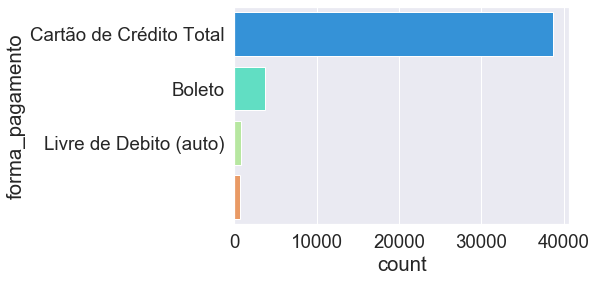

In [48]:
sns.countplot(y='forma_pagamento', data=dados_agrupados,
              order = dados_agrupados['forma_pagamento'].value_counts().index,palette="rainbow")

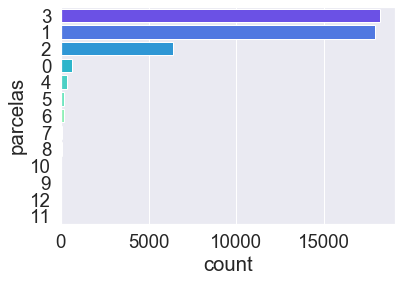

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(y='parcelas', data=dados_agrupados,
              order = dados_agrupados['parcelas'].value_counts().index,palette="rainbow")

Na forma de pagamento de cartão de crédito, o número de parcelas 3,1,2 são as mais escolhidas pelos cliente. 

### Contagem de pedidos

O número de contagem máxima de pedidos de cada cliente não interfere na receita da loja.
Porém, a partir dessa variável, podemos classificar os clientes por nível de fidelidade de acordo com o número de pedidos que já fizeram.

In [50]:
# O cliente que mais comprou na Petlov fez 651 pedidos, e temos clientes que nunca compraram
min(dados_agrupados['contagempedidos']),max(dados_agrupados['contagempedidos'])

(0, 651)

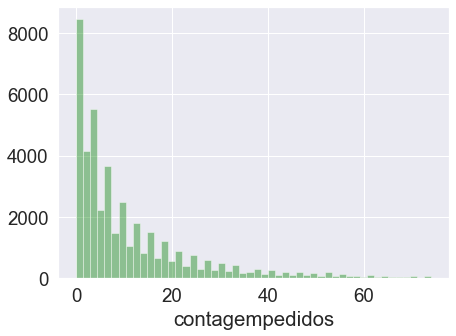

In [51]:
plt.figure(figsize=(7,5))
sns.distplot(dados_agrupados[dados_agrupados['contagempedidos']<75]['contagempedidos'],kde=False,color='green')

In [52]:
dados_agrupados[dados_agrupados['contagempedidos']<75]['contagempedidos'].mean()

11.33373402066622

Pela distribuição dos valores de contagempedidos, observamos que a média de pedidos por cliente é 11.3. A partir deste valor, podemos definir três categorias de clientes: regular, fiel e vip. Clientes com até 15 compras no cadastro é classificado como regular, clientes com números de pedidos de 15 a 35 são fiéis e acima de 35 são vips.
A inserção das categorias e coluna tipocliente foi feita quando importamos os dados com o SQL no início do notebook.

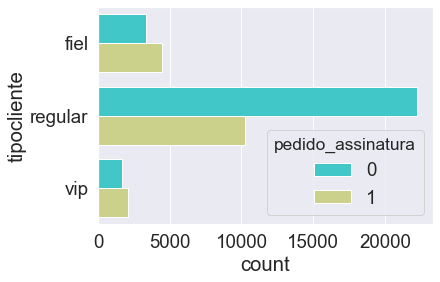

In [53]:
sns.countplot(y='tipocliente', hue='pedido_assinatura',data=dados_agrupados,palette="rainbow")

O tipo mais comum de cliente é o regular, que possue até 15 números de pedidos no cadastro.

In [54]:
# Temos apenas 44 clientes que possuem 0 compras feitas no site. 
#Este número não é significante no conjunto de dados do site.

len(dados_agrupados[dados_agrupados['contagempedidos']==0])

44

### Receita por produto

In [55]:
receita_produto=dados_gerais.groupby('codigo_produto_mask').sum()[['receita']]
receita_produto['receita%']=receita_produto['receita']*100/sum(receita_produto['receita'])
receita_produto['vendidos']=dados_gerais.groupby('codigo_produto_mask')[['codigo_produto_mask']].count()

In [56]:
receita_produto.describe()

,receita,receita%,vendidos
count,11521.000000,11521.000000,11521.000000
mean,1142.808476,0.008680,19.146515
std,5004.480157,0.038010,61.505700
min,0.000000,0.000000,1.000000
25%,62.910000,0.000478,1.000000
50%,164.610000,0.001250,4.000000
75%,546.440000,0.004150,11.000000
max,214916.460000,1.632323,1132.000000


In [57]:
# Valor máximo e mínimo de unidades vendidas de um produto
max(receita_produto['vendidos']),min(receita_produto['vendidos'])

(1132, 1)

In [58]:
# Quantos produtos tiveram apenas 1 unidade vendida,a porcentagem no total de vendas e % da receita
receita_produto[receita_produto['vendidos']==1]['vendidos'].count(),receita_produto[receita_produto['vendidos']==1]['vendidos'].count()*100/len(receita_produto),receita_produto[receita_produto['vendidos']==1]['receita%'].sum()

(3129, 27.159100772502388, 1.9872134202173097)

27.2% dos produtos do site tiveram apenas 1 unidade vendida. Esses produtos correspondem a aproximadamente 2% da receita total.

In [59]:
# Quantos produtos tiveram 10 ou menos unidades vendidas, a porcentagem no total de vendas e % da receita
receita_produto[receita_produto['vendidos']<=10]['vendidos'].count(),receita_produto[receita_produto['vendidos']<=10]['vendidos'].count()*100/len(receita_produto),receita_produto[receita_produto['vendidos']<=10]['receita%'].sum()

(8442, 73.27488933252322, 12.99006426366747)

Os produtos com 10 ou menos unidades vendidas, correspondem a 73% dos produtos e 13% das vendas

In [60]:
# Quantos produtos tiveram 50 ou mais unidades vendidas, a porcentagem no total de vendas e % da receita
receita_produto[receita_produto['vendidos']>=50]['vendidos'].count(),receita_produto[receita_produto['vendidos']>=50]['vendidos'].count()*100/len(receita_produto),receita_produto[receita_produto['vendidos']>=50]['receita%'].sum()

(900, 7.811821890460897, 62.32569341851521)

Os produtos com 50 ou mais unidades vendidas, correspondem a 8% dos produtos do site e a 62% da receita.

Estes valores indicam que muitos produtos não geram receita e talvez devam ser retirados do site. Essa questão pode ser avaliada por algum profissional que entenda do mercado de pet shop, para tentar eliminar alguns produtos sem saída e que possivelmente geram algum custo de armazenamento. 
Mesmo sem conhecimento na área é razoável assumir que 27% é um número muito alto para produtos que possuem apenas 1 venda.


### Uniformização das variavéis

Depois de explorarmos os dados de forma geral e analisarmos como os pedidos de assinatura e brinde afetam a receita, vamos utilizar algumas ferramentas de machine learning para ver quais variáveis funcionam como alavancas de venda.
Porém antes disso, precisamos uniformizar as variáveis. 

In [61]:
# Transformar canal_marketing, tipocliente e canal_venda em dummies, 
# pois elas são utilizadas apenas para classificar uma categoria e não serve um valor de medida.

canal_marketing=pd.get_dummies(dados_agrupados['canal_marketing'], 
                               drop_first=True,dtype=int).rename(columns=lambda x: 'canalmarketing_' + str(x))
tipocliente=pd.get_dummies(dados_agrupados['tipocliente'], drop_first=True,dtype=float)
canal_venda=pd.get_dummies(dados_agrupados['canal_venda'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'canalvenda_' + str(x))

In [62]:
# Uniformizar as variáveis numéricas com StandarScaler, menos nas variavéis dummy

from sklearn.preprocessing import StandardScaler

pedido_assinatura=dados_agrupados['pedido_assinatura']

scaled=dados_agrupados[['quantidade', 'receita','brinde', 'frete', 'desconto', 
                        'contagempedidos', 'peso_pedido','parcelas']]
ss = StandardScaler().fit_transform(scaled)

scaled_agrupados=dados_agrupados.copy()

scaled_agrupados[['quantidade','receita', 'brinde', 'frete', 'desconto', 
                        'contagempedidos', 'peso_pedido','parcelas']]=ss

scaled_agrupados['pedido_assinatura']=pedido_assinatura.astype('int64')

# reintroduzir as variáveis dummy no dataset

scaled_agrupados[canal_marketing.columns]=canal_marketing
scaled_agrupados=scaled_agrupados.drop('canal_marketing',1)

scaled_agrupados[canal_venda.columns]=canal_venda
scaled_agrupados=scaled_agrupados.drop('canal_venda',1)

scaled_agrupados[tipocliente.columns]=tipocliente
scaled_agrupados=scaled_agrupados.drop('tipocliente',1)

Algumas variavéis como peso e quantidade estão relacionadas com a receita, mas não são uma alavanca de receita.
Intuitivamente se um pedido é composto por mais itens, ele deve gerar uma receita maior do que um pedido com menos itens.
O mesmo vale para o peso_pedido, uma ração de 20kg vai gerar mais receita do que uma de 3kg (considerando a mesma marca), porém o motivo é simplesmente porquê o saco de 20kg é mais caro. O peso em si não interfere na receita da empresa. Portanto, as variáveis peso_pedido e quantidade não serão utilizadas no próximo passo.

In [63]:
from sklearn.model_selection import train_test_split

X=scaled_agrupados.drop(['id_pedido_mask','contagempedidos', 'id_usuario_mask','receita',
                         'subcanal_venda','forma_pagamento','quantidade','parcelas','peso_pedido'],1)
y=dados_agrupados['receita']
y_scaled=scaled_agrupados['receita']

# No nosso problema, não queremos gerar um modelo preditivo usando machine learning, portanto não é necessário
# dividir o conjunto de dados em treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Feature selection e exploração de padrões

Apenas manipulando as tabelas, vimos que os assinantes pet love possuem uma média de 2x mais pedidos (por cliente) e também que pedidos que contém brindes correspondem a 62% da receita. Sendo assim, é esperado que desconto, brindes estejam entre as principais features.

Nesta etapa vamos utilizar as técnicas SeleckKBest, RFE e o método de feature importance para identificar quais são as variáveis mais importantes para determinar o valor da receita. 

#### SelectKBest

In [64]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

s = SelectKBest(f_classif, k = 5)

X_s = s.fit_transform(X, y)
nomes = X.columns.values[s.get_support()]
scores = s.scores_[s.get_support()]
nomes_score = list(zip(nomes, scores))
tab = pd.DataFrame(data = nomes_score, columns=['feature', 'score'])
selectkbest = tab.sort_values(['score', 'feature'], ascending = [False, True])
selectkbest

,feature,score
2,desconto,3.565807
1,frete,2.665624
0,brinde,2.427557
3,canalmarketing_decc1eab6d0751fcb2d8e41a2ffeb55a,1.484965
4,canalvenda_a564de63c2d0da68cf47586ee05984d7,1.484965


#### RFE

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

model = RandomForestRegressor(max_features='auto',n_estimators=500,
                           min_samples_leaf=10,oob_score = True,criterion='mse',
                           n_jobs = -1,random_state =42,bootstrap=True,max_depth=100) 
model.fit(X,y)
rfe = RFE(model, 5)

fit = rfe.fit(X, y)

X_rfe = fit.fit_transform(X, y)
nomes = X.columns.values[fit.get_support()]
scores = fit.get_support()
nomes_score = list(zip(nomes, scores))
tab = pd.DataFrame(data = nomes_score, columns=['feature', 'score'])
rfe = tab.sort_values(['score', 'feature'], ascending = [False, True])
rfe

,feature,score
3,canalmarketing_decc1eab6d0751fcb2d8e41a2ffeb55a,True
2,desconto,True
1,frete,True
0,brinde,False
4,canalvenda_a564de63c2d0da68cf47586ee05984d7,False


#### Feature importance method

In [66]:
rf_featureimportance = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
rf_featureimportance[:5]

,importance
desconto,0.757231
frete,0.123143
brinde,0.084874
regular,0.005011
canalmarketing_decc1eab6d0751fcb2d8e41a2ffeb55a,0.004149


Agora que já conhecemos as variáveis que servem de alavanca para a receita, podemos tentar identificar padrões que possam ajudar a entender o comportamento do consumidor:

#### Principais alavancas de vendas:  

desconto, frete, brinde, regular, canalmarketing_decc1eab6d0751fcb2d8e41a2ffeb55a,canalvenda_a564de63c2d0da68cf47586ee05984d7

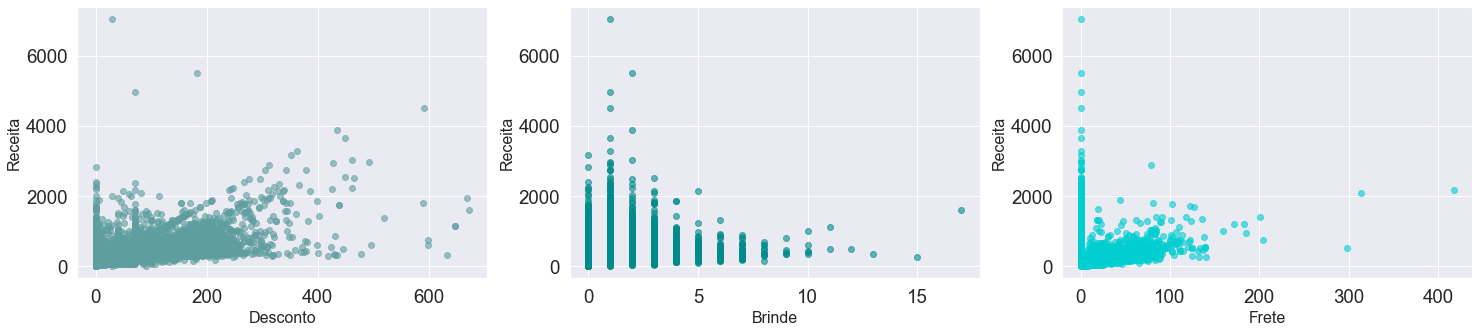

In [67]:
# Visualização das variáveis mais relevantes

fig,(ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=(25,5))
ax1.scatter(dados_agrupados['desconto'],dados_agrupados['receita'],c='cadetblue',alpha=0.6)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Desconto', fontsize = 16)

ax2.scatter(dados_agrupados['brinde'],dados_agrupados['receita'],c='darkcyan',alpha=0.6)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Brinde', fontsize = 16)

ax3.scatter(dados_agrupados['frete'],dados_agrupados['receita'],c='darkturquoise',alpha=0.6)
ax3.set_ylabel('Receita', fontsize = 16)

ax3.set_xlabel('Frete', fontsize = 16)
plt.show()


Nos gráficos acima, vemos uma certa tendência linear entre receita x desconto e receita x frete. Vemos que compras que possuem entre 0 e 5 brindes, concentram a maior parte da receita. 
Apesar de observar esses comportamentos no gráfico, fica difícil concluir alguma coisa baseado apenas nessas informações.
Para tentar melhorar a visualização e interpretação dos dados, podemos separar cada uma das variáveis acima nas categorias tipo cliente.

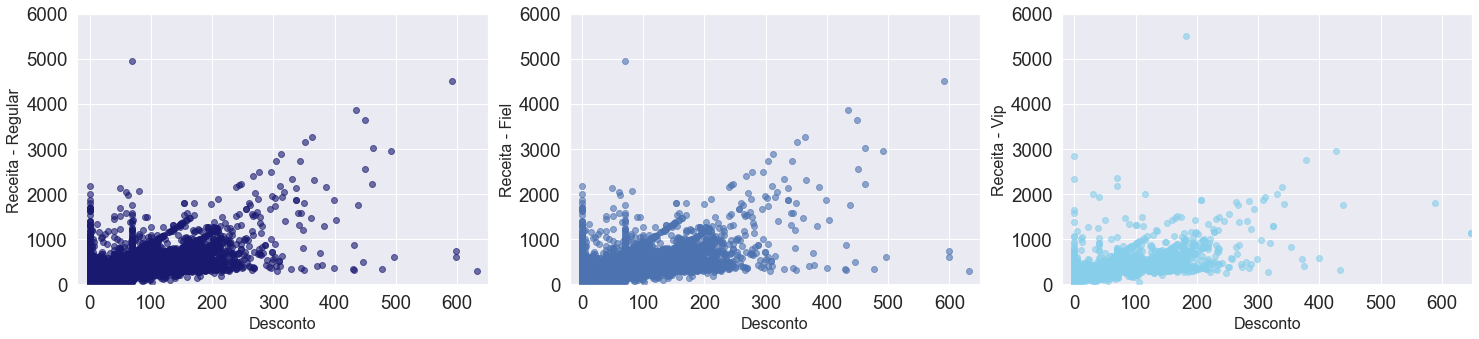

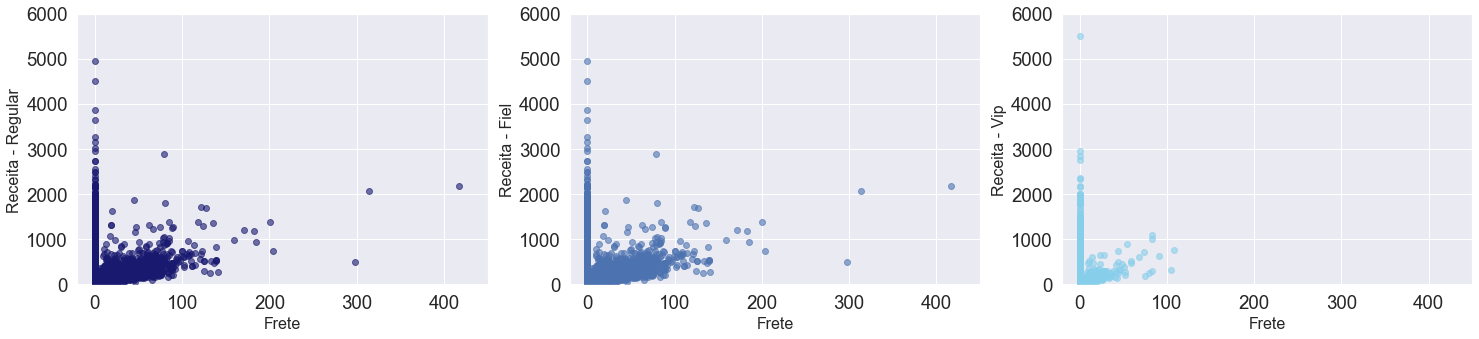

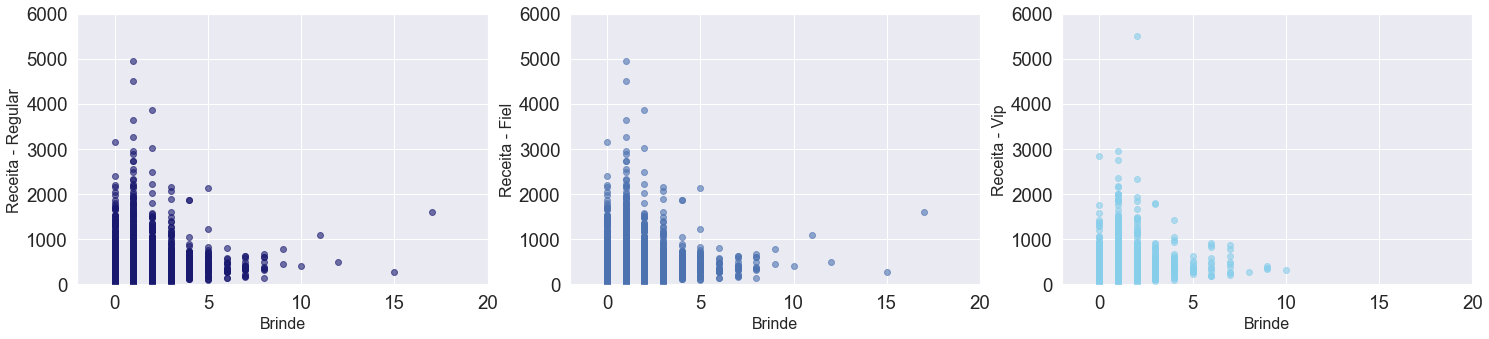

In [68]:
# Visualização das variáveis mais relevantes

fig,(ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=(25,5))
ax1.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['desconto'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],c='midnightblue',alpha=0.6)
ax1.set_ylabel('Receita - Regular', fontsize = 16)
ax1.set_xlabel('Desconto', fontsize = 16)
ax1.set_xlim(-20, 650)
ax1.set_ylim(-20, 6000)
ax2.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['desconto'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],alpha=0.6)
ax2.set_ylabel('Receita - Fiel', fontsize = 16)
ax2.set_xlabel('Desconto', fontsize = 16)
ax2.set_xlim(-20, 650)
ax2.set_ylim(-20, 6000)
ax3.scatter(dados_agrupados[dados_agrupados['tipocliente']=='vip']['desconto'],
                dados_agrupados[dados_agrupados['tipocliente']=='vip']['receita'],c='skyblue',alpha=0.6)
ax3.set_ylabel('Receita - Vip', fontsize = 16)
ax3.set_xlim(-20, 650)
ax3.set_ylim(-20, 6000)
ax3.set_xlabel('Desconto', fontsize = 16)
plt.show()


fig,(ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=(25,5))
ax1.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['frete'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],c='midnightblue',alpha=0.6)
ax1.set_ylabel('Receita - Regular', fontsize = 16)
ax1.set_xlabel('Frete', fontsize = 16)
ax1.set_xlim(-20, 450)
ax1.set_ylim(-20, 6000)
ax2.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['frete'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],alpha=0.6)
ax2.set_ylabel('Receita - Fiel', fontsize = 16)
ax2.set_xlabel('Frete', fontsize = 16)
ax2.set_xlim(-20, 450)
ax2.set_ylim(-20, 6000)
ax3.scatter(dados_agrupados[dados_agrupados['tipocliente']=='vip']['frete'],
                dados_agrupados[dados_agrupados['tipocliente']=='vip']['receita'],c='skyblue',alpha=0.6)
ax3.set_ylabel('Receita - Vip', fontsize = 16)
ax3.set_xlim(-20, 450)
ax3.set_ylim(-20, 6000)
ax3.set_xlabel('Frete', fontsize = 16)
plt.show()


fig,(ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=(25,5))
ax1.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['brinde'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],c='midnightblue',alpha=0.6)
ax1.set_ylabel('Receita - Regular', fontsize = 16)
ax1.set_xlabel('Brinde', fontsize = 16)
ax1.set_xlim(-2, 20)
ax1.set_ylim(-20, 6000)
ax2.scatter(dados_agrupados[dados_agrupados['tipocliente']=='regular']['brinde'],
                dados_agrupados[dados_agrupados['tipocliente']=='regular']['receita'],alpha=0.6)
ax2.set_ylabel('Receita - Fiel', fontsize = 16)
ax2.set_xlabel('Brinde', fontsize = 16)
ax2.set_xlim(-2, 20)
ax2.set_ylim(-20, 6000)
ax3.scatter(dados_agrupados[dados_agrupados['tipocliente']=='vip']['brinde'],
                dados_agrupados[dados_agrupados['tipocliente']=='vip']['receita'],c='skyblue',alpha=0.6)
ax3.set_ylabel('Receita - Vip', fontsize = 16)
ax3.set_xlim(-2, 20)
ax3.set_ylim(-20, 6000)
ax3.set_xlabel('Brinde', fontsize = 16)
plt.show()




O conjunto acima, mostra uma divisão de categoria de clientes bem simplista baseada somente nos números de pedidos de cada cliente. 
Podemos observar algumas difrenças entre eles, os clientes regulares ganham mais brindes, descontos, porém não ganham benefícios no frete. Enquanto que os VIPs, ganham menos brinde e desconto, porém gastam menos com frete.

Para melhorar nossa análise, é necessário identificar grupos de comportamento parecido de uma forma eficiênte. Para isso, utilizaremos kmeans clustering.

### Kmeans clustering

In [69]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

Iremos achar o melhor valor de n_clustering pelo método do cotovelo e silhueta. 

In [70]:
# Para achar o n ótimo, precisamos calcular o wcss
def calculate_wcss(inp):
    wcss = []
    for n in range(1, 11):
        initial=inp.head(n)
        kmeans = KMeans(n_clusters=n)#init=initial,n_init=1)
        kmeans.fit(X=inp)
        wcss.append((n,kmeans.inertia_))
    wcss=pd.DataFrame(wcss)
    wcss.columns=['n','kmeans.inertia']        
    return wcss

# Como nem sempre é fácil identificar com o olho o melhor ponto, vamos utilizar uma função para isso

def calculate_sil(inp,kmax):
    sil = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(inp)
        labels = kmeans.labels_
        sil.append((k,silhouette_score(X, labels, metric = 'euclidean')))
    sil=pd.DataFrame(sil)
    sil.columns=['n','sil']    
    return sil
    
def otimizar_cluster(wcss):
    wcss=wcss.values.tolist()
    x1, y1 = wcss[0][0], wcss[0][1]
    x2, y2 =  wcss[len(wcss)-1][0], wcss[len(wcss)-1][1]
    distances = []
    for i in range(len(wcss)):
        x0 = wcss[i][0]
        y0 = wcss[i][1]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)   
    return distances.index(max(distances))+1

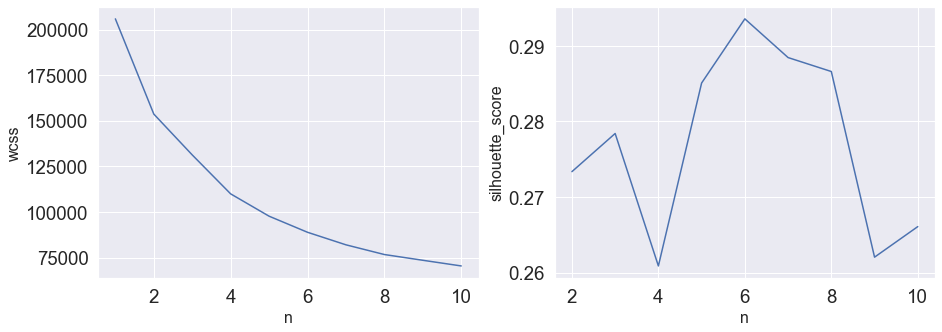

In [71]:
# Calcular os valores de wcss e do gráfico silhueta com as funções definidas acima
wcss=calculate_wcss(X)
sil=calculate_sil(X,10)

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.plot(wcss['n'],wcss['kmeans.inertia'])
ax1.set_ylabel('wcss', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax2.plot(sil['n'], sil['sil'])
ax2.set_ylabel('silhouette_score', fontsize = 16)
ax2.set_xlabel('n', fontsize = 16)
plt.show()

No gráfico wcss x n não fica muito claro qual o valor de n, podemos utilizar o gráfico silhueta e achar o ponto mais alto facilmente. Também podemos usar a função que foi feita logo acima para calcular o valor ótimo de n:

In [72]:
k=otimizar_cluster(wcss)
k

4

In [73]:
# Kmeans clustering é aplicado no conjunto de dados após otimização do valor de n_clusters
kmeans = KMeans(n_clusters=k) 
kmeans.fit(X)
dados_agrupados['kmeans']=kmeans.labels_

Visualização gráfica dos clusteres:

Text(0, 0.5, 'Receita ')

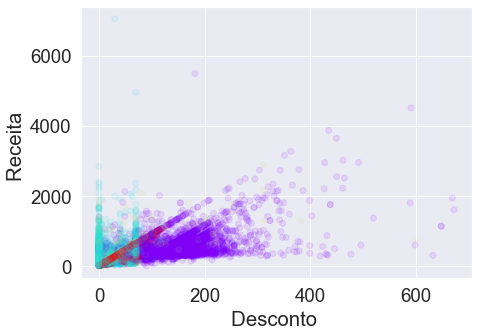

In [74]:
# Receita x desconto
plt.close()
plt.figure(figsize=(7,5))
plt.scatter(dados_agrupados['desconto'], dados_agrupados['receita'], c=kmeans.labels_, cmap='rainbow',alpha=0.1)

plt.xlabel('Desconto ')
plt.ylabel('Receita ')

Pelo gráfico acima, não fica claro a distinção entre os clusteres, então vamos plotar individualmente:

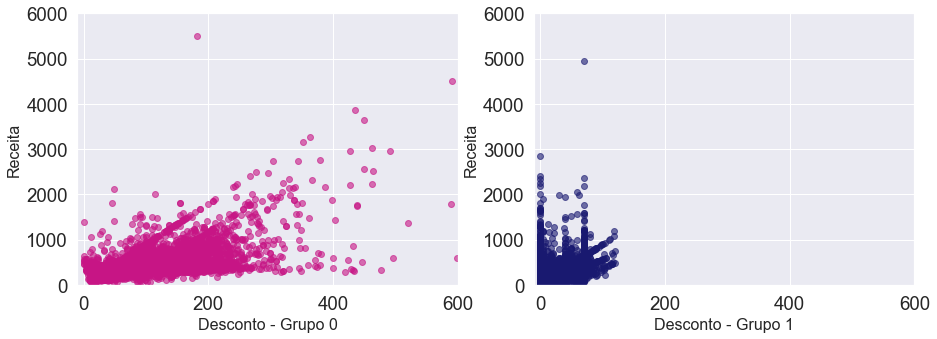

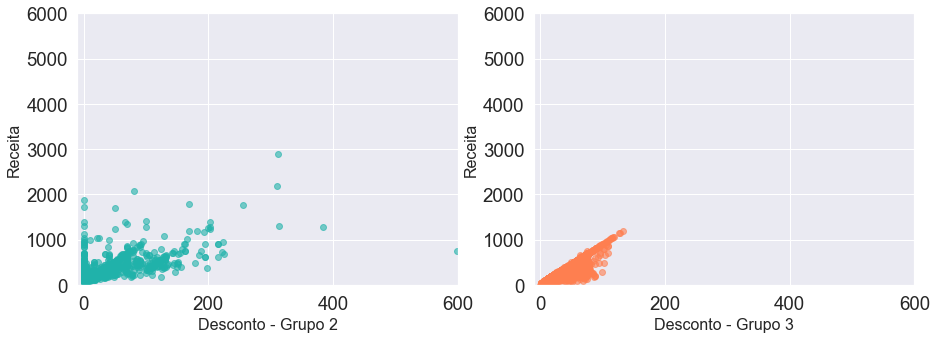

In [75]:
fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==0]['desconto'], 
            dados_agrupados[dados_agrupados['kmeans']==0]['receita'],c='mediumvioletred',alpha=0.6)
ax1.set_xlim(-10,600)
ax1.set_ylim(-10,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Desconto - Grupo 0', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==1]['desconto'], 
            dados_agrupados[dados_agrupados['kmeans']==1]['receita'],c='midnightblue',alpha=0.6)
ax2.set_xlim(-10,600)
ax2.set_ylim(-10,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Desconto - Grupo 1', fontsize = 16)

plt.show()

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==2]['desconto'], 
            dados_agrupados[dados_agrupados['kmeans']==2]['receita'],c='lightseagreen',alpha=0.6)
ax1.set_xlim(-10,600)
ax1.set_ylim(-10,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Desconto - Grupo 2', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==3]['desconto'], 
            dados_agrupados[dados_agrupados['kmeans']==3]['receita'],c='coral',alpha=0.6)
ax2.set_xlim(-10,600)
ax2.set_ylim(-10,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Desconto - Grupo 3', fontsize = 16)
plt.show()


Por kmeans clustering, obtemos 4 grupos com comportamentos parecidos dentro dos nossos dados.
Os gráficos acima correspondem a Receita x desconto para os 4 grupos.
Com a modelagem por kmeans, a divisão dos grupos foi muito mais eficiente que a feita utilizando apenas contagempedidos no início.

- Grupo 0: forte dependência linear entre receita e desconto, possui valores baixos/médios de receita e desconto.
- Grupo 1: grande concentração de pedidos com alta receita em compras sem desconto ou baixo/médio desconto.
- Grupo 2: dependência linear entre receita e desconto, possui grande concentração de pedidos com baixo/médioe receita média/alta.
- Grupo 3: forte dependência linear entre receita e desconto, possui valores médios/altos de receita e desconto. 


Text(0, 0.5, 'receita')

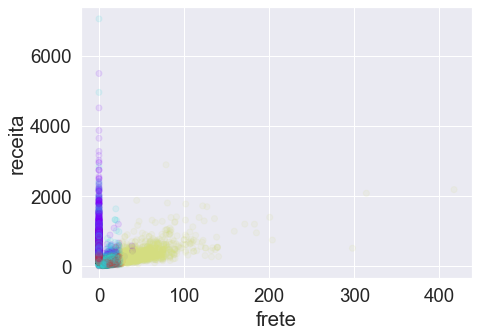

In [76]:
# Receita x frete

plt.figure(figsize=(7,5))
plt.scatter(dados_agrupados['frete'], dados_agrupados['receita'], c=kmeans.labels_, cmap='rainbow',alpha=0.1)

plt.xlabel('frete')
plt.ylabel('receita')

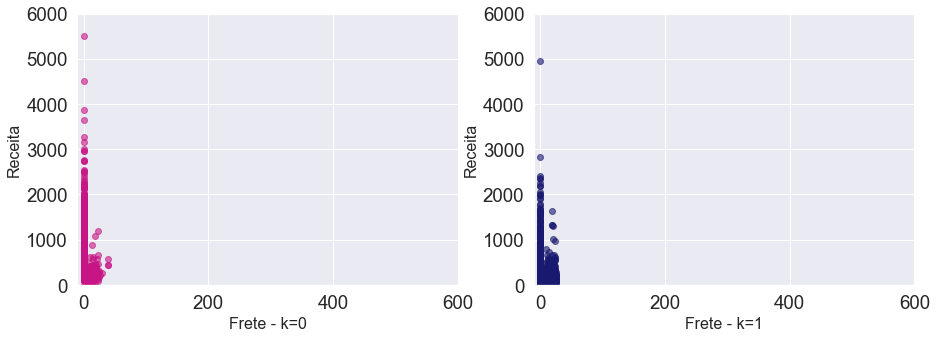

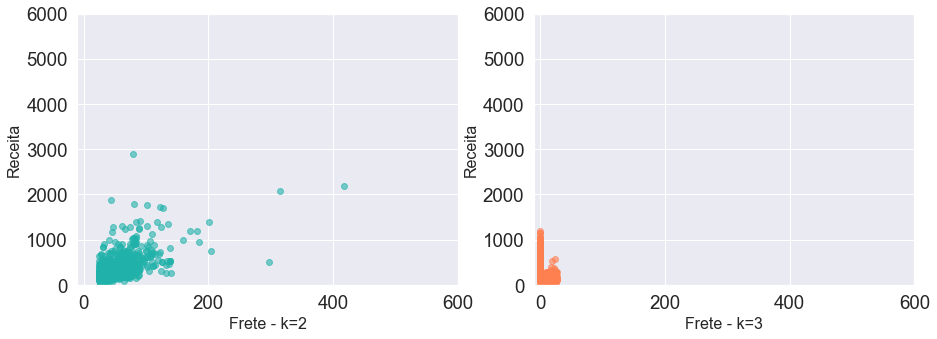

In [77]:
fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==0]['frete'], 
            dados_agrupados[dados_agrupados['kmeans']==0]['receita'],c='mediumvioletred',alpha=0.6)
ax1.set_xlim(-10,600)
ax1.set_ylim(-10,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Frete - k=0', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==1]['frete'], 
            dados_agrupados[dados_agrupados['kmeans']==1]['receita'],c='midnightblue',alpha=0.6)
ax2.set_xlim(-10,600)
ax2.set_ylim(-10,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Frete - k=1', fontsize = 16)

plt.show()

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==2]['frete'], 
            dados_agrupados[dados_agrupados['kmeans']==2]['receita'],c='lightseagreen',alpha=0.6)
ax1.set_xlim(-10,600)
ax1.set_ylim(-10,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Frete - k=2', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==3]['frete'], 
            dados_agrupados[dados_agrupados['kmeans']==3]['receita'],c='coral',alpha=0.6)
ax2.set_xlim(-10,600)
ax2.set_ylim(-10,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Frete - k=3', fontsize = 16)
plt.show()

Pelos gráficos acima, podemos identificar as seguintes características de cada grupo:

- Grupo 0: compras com baixa/média receita e com valores baixos/médios de frete.
- Grupo 1: compras com média/alta receita, porém com valores baixos/médios de frete.
- Grupo 2: compras com baixa/média receita e realizadas com valores altos de frete.
- Grupo 3: compras com média/alta receita, porém com baixos/médios de frete. 

Text(0, 0.5, 'receita')

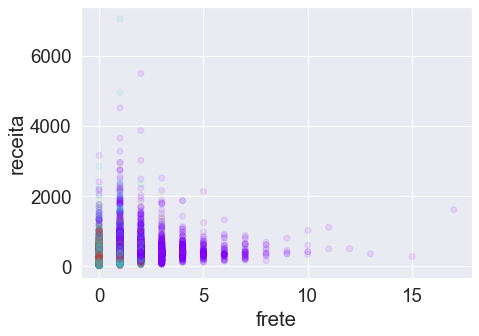

In [78]:
# Receita x brinde

plt.figure(figsize=(7,5))
plt.scatter(dados_agrupados['brinde'], dados_agrupados['receita'], c=kmeans.labels_, cmap='rainbow',alpha=0.1)

plt.xlabel('frete')
plt.ylabel('receita')

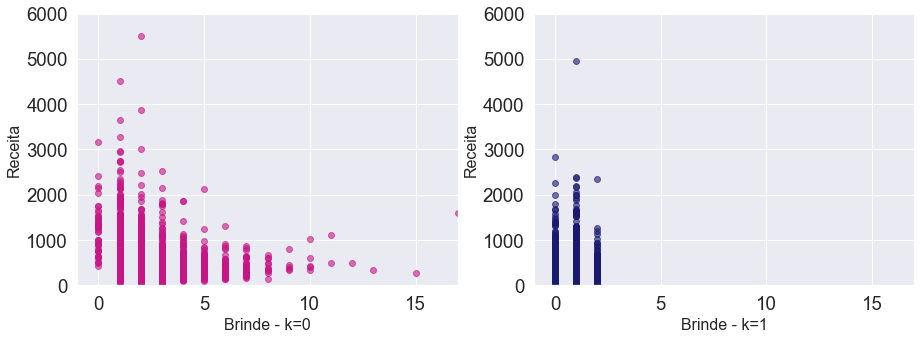

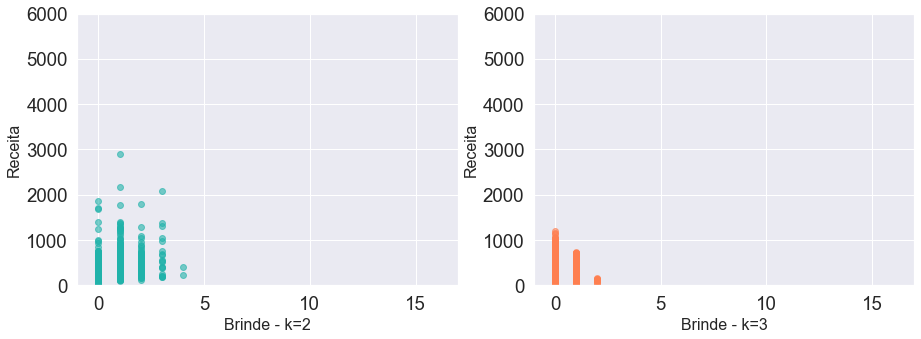

In [79]:
fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==0]['brinde'], 
            dados_agrupados[dados_agrupados['kmeans']==0]['receita'],c='mediumvioletred',alpha=0.6)
ax1.set_xlim(-1,17)
ax1.set_ylim(-1,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Brinde - k=0', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==1]['brinde'], 
            dados_agrupados[dados_agrupados['kmeans']==1]['receita'],c='midnightblue',alpha=0.6)
ax2.set_xlim(-1,17)
ax2.set_ylim(-1,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Brinde - k=1', fontsize = 16)

plt.show()

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.scatter(dados_agrupados[dados_agrupados['kmeans']==2]['brinde'], 
            dados_agrupados[dados_agrupados['kmeans']==2]['receita'],c='lightseagreen',alpha=0.6)
ax1.set_xlim(-1,17)
ax1.set_ylim(-1,6000)
ax1.set_ylabel('Receita', fontsize = 16)
ax1.set_xlabel('Brinde - k=2', fontsize = 16)
ax2.scatter(dados_agrupados[dados_agrupados['kmeans']==3]['brinde'], 
            dados_agrupados[dados_agrupados['kmeans']==3]['receita'],c='coral',alpha=0.6)
ax2.set_xlim(-1,17)
ax2.set_ylim(-1,6000)
ax2.set_ylabel('Receita', fontsize = 16)
ax2.set_xlabel('Brinde - k=3', fontsize = 16)
plt.show()

Pelos gráficos acima, podemos identificar as seguintes características de cada grupo:

- Grupo 0: compras com baixa/média receita e poucos brindes.
- Grupo 1: compras com média/alta receita e poucos brindes.
- Grupo 2: compras com baixa/média receita e poucos brindes.
- Grupo 3: compras com média/alta receita e muitos brindes. 

Text(0, 0.5, 'Grupo Cliente')

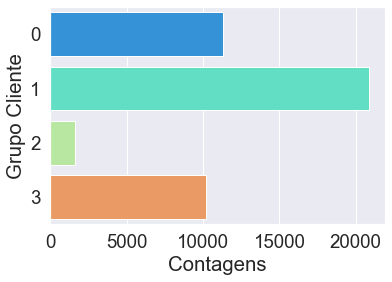

In [80]:
sns.countplot(y='kmeans',data=dados_agrupados,palette="rainbow")
plt.xlabel("Contagens")
plt.ylabel("Grupo Cliente")
#O grupo 2 corresponde a grande maioria dos clientes pet love.

Cálculo da porcentagem de brinde, receita, desconto e contagem pedidos para os diferentes grupos.

<Figure size 1440x576 with 0 Axes>

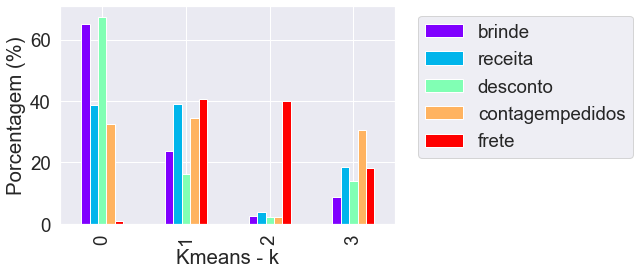

In [81]:
porcentagens_k=pd.DataFrame()
porcentagens_k['brinde']=dados_agrupados.groupby('kmeans')['brinde'].sum()*100/sum(dados_agrupados['brinde'])
porcentagens_k['receita']=dados_agrupados.groupby('kmeans')['receita'].sum()*100/sum(dados_agrupados['receita'])
porcentagens_k['desconto']=dados_agrupados.groupby('kmeans')['desconto'].sum()*100/sum(dados_agrupados['desconto'])
porcentagens_k['contagempedidos']=dados_agrupados.groupby(['kmeans'])['contagempedidos'].sum()*100/sum(dados_agrupados['contagempedidos'])
porcentagens_k['frete']=dados_agrupados.groupby(['kmeans'])['frete'].sum()*100/sum(dados_agrupados['frete'])

porcentagens_k=round(porcentagens_k,2)

plt.figure(figsize=(20,8))
porcentagens_k.plot(kind='bar', cmap="rainbow")
plt.xlabel('Kmeans - k')
plt.ylabel('Porcentagem (%)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


Aqui, cada vez que compila o notebook os valores de k de cada grupo podem mudar e a descrição abaixo ficar confusa.

Com as informações do gráfico acima e os gráficos que analisamos com a separação dos grupos, podemos ter uma uma melhor compreensão de como se comporta cada grupo:

- Grupo 0: São clientes responsáveis por cerca de 35% dos pedidos e 40% da receita da empresa. Estes clientes recebem cerca de 65% de todo o desconto, 65% do total de brindes e contribuem com menos de 5% do valor total de frete. Ou seja, junto com o grupo 1, são os clientes que mais geram receita. Porém não pagam e frete e são altamente contemplados com brindes e descontos.



- Grupo 1: São clientes responsáveis por cerca de 35% dos pedidos e 40% da receita da empresa. Estes clientes recebem cerca de 15% de todo o desconto, 25% do total de brindes e contribuem com cerca de 40% do valor total de frete. Ou seja, são os clientes que mais gastam em receita e frete -  somente esta categoria é responsável por 40% da receita. Apesar de não serem contemplados com muito desconto, esta categoria é a segunda que mais recebe brindes. Este é o maior grupo em número de tipos de clientes empresa.


- Grupo 2: São clientes responsáveis por cerca de menos de 5% dos pedidos e da receita da empresa. Estes clientes recebem cerca de 5% de todo o desconto, menos de 5% do total de brindes e contribuem com cerca de 40% do valor total de frete. Ou seja, são clientes que contribuem muito pouco com a receita, não ganham brindes ou desconto, porém pagam altos valores de frete.


- Grupo 3: São clientes responsáveis por cerca de 30% dos pedidos e 20% da receita da empresa. Estes clientes recebem cerca de 15% de todo o desconto, 10% do total de brindes e contribuem com cerca de 20% do valor total de frete. Ou seja, são clientes que compram bastante (aproximadamente 35% dos pedidos totais), porém contribuem menos para a receita que os outros grupos. Além disso, eles são menos contemplados com descontos e brindes.



### Fazer um modelo preditivo com as novas classificações de clientes obtidas com kmeans

O método kmeans clustering permitiu identificar o perfil dos diferentes grupos de clientes. Podemos utilizar a classificação dos clientes, para criarmos um modelo preditivo e assim observar quais mudanças e para quais grupo irão aumentar a receita da empresa.

Nesta etapa, utilizaremos o dataframe dados_gerais e adicionaremos a ele as informações de classificação geradas pelo kmeans clustering.

In [82]:
dados_modelo=pd.DataFrame()
dados_modelo=dados_gerais.copy()


In [83]:
# Criaremos variáveis dumies para as categorias setor, canal_marketing, canal_venda e familia

setor_modelo=pd.get_dummies(dados_gerais['setor'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'setor_' + str(x))
marketing_modelo=pd.get_dummies(dados_gerais['canal_marketing'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'marketing_' + str(x))
vendas_modelo=pd.get_dummies(dados_gerais['canal_venda'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'vendas_' + str(x))
familia_modelo=pd.get_dummies(dados_gerais['familia'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'vendas_' + str(x))


In [85]:
# Uniformizar as variáveis numéricas com StandarScaler, menos nas variavéis dummy

from sklearn.preprocessing import StandardScaler


scaled=dados_gerais[[ 'quantidade', 'frete', 'desconto', 'brinde',
                             'contagempedidos', 'parcelas','peso_unitario']]

sg = StandardScaler().fit_transform(scaled)

scaled_gerais=dados_gerais.copy()

scaled_gerais[['quantidade', 'frete', 'desconto', 'brinde',
                             'contagempedidos', 'parcelas','peso_unitario']]=sg


# reintroduzir as variáveis dummy no dataset

scaled_gerais[marketing_modelo.columns]=marketing_modelo

scaled_gerais[vendas_modelo.columns]=vendas_modelo
scaled_gerais[setor_modelo.columns]=setor_modelo
scaled_gerais[familia_modelo.columns]=familia_modelo
scaled_gerais['pedido_assinatura']=dados_gerais['pedido_assinatura']

In [86]:
# Temos que juntar a dataframe scaled_gerais com os valores obtidos pelo kmeans
u=dados_agrupados[['id_usuario_mask','kmeans']]

dados_merged = pd.merge(scaled_gerais,u,on='id_usuario_mask', how='left')
dados_merged=dados_merged.dropna()
kmeans_modelo=pd.get_dummies(dados_merged['kmeans'], 
                           drop_first=True,dtype=int).rename(columns=lambda x: 'kmeans_' + str(x))
dados_merged[kmeans_modelo.columns]=kmeans_modelo
dados_merged=dados_merged.drop(['id_pedido_mask', 'id_usuario_mask','kmeans', 'codigo_produto_mask', 'forma_pagamento',
                                  'canal_venda', 'subcanal_venda','setor', 'familia','subfamilia','canal_marketing'],1)

#### Dividir os dados em treino e teste

In [87]:
# Criar um conjunto de teste e treino
X=dados_merged.drop('receita',1)
y=dados_merged['receita']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Criar os modelos

Random forest

In [88]:
# rf teve um score de 0.94
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features='auto',n_estimators=300,oob_score = True,
                           n_jobs = -1,random_state =42,bootstrap=True,max_depth=100) 
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9175115388787393

Gradient Boosting

In [89]:
# GradientBoosting teve score de 0.89
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor(max_features='auto', loss='ls', n_estimators=1000,alpha=0.95)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.8986363461699404

Como o RF obteve melhor desempenho, iremos continuar com ele.

Em número de pedidos, os clientes do grupo 0 estão na mesma porcentagem que os do grupo 1 e 3. No entando, a receita deste grupo é mais baixa. Como vimos anteriormente, este grupo recebe menos incentivos como descontos e brindes. Uma maneira de fazer com que este grupo gere mais receitas nas suas compras seria oferecendo descontos e brindes.
O mesmo vale para o grupo 1, em comparação com o grupo 3, ele gera renda e número de pedidos similares, porém ganham menos incentivos e pagam mais frete.
Portanto, uma solução seria diminuir os descontos e brindes do grupo 3, e aumentar o ofereceimento destes incentivos aos grupos 0 e 1.
O grupo 2 não gera renda significante e a empresa não investe muito nele também, portanto ele continuará assim.

 Vamos agora alterar o X_test, faremos com que os grupos 0 e 1 recebam 10% a mais de desconto e 10% a mais de brinde. Ao mesmo tempo, removeremos 10% de desconto e de brindes do grupo 3.

In [96]:
X_test_new=X_test.copy()
X_test_new
kmeans_0 = X_test_new.loc[(X_test_new["kmeans_1.0"] == 0)&(X_test_new["kmeans_2.0"] == 0)&(X_test_new["kmeans_3.0"] == 0)]
kmeans_1 = X_test_new.loc[(X_test_new["kmeans_1.0"] == 1)]
kmeans_2 = X_test_new.loc[(X_test_new["kmeans_2.0"] == 1)]
kmeans_3 = X_test_new.loc[(X_test_new["kmeans_3.0"] == 1)]

Vamos reduzir os beneficios do grupo 0 e 3 e aumentar dos grupos 1 e 2.

In [98]:
desc0=0.9
desc1=1.3
desc3=1.2
desc2=0.5
brinde0=0.5
brinde3=1.3
brinde1=1.2
brinde2=0.5

kmeans_0.loc[:,['desconto']]=kmeans_0.loc[:,['desconto']].values*desc0
kmeans_0.loc[:,['brinde']]=kmeans_0.loc[:,['brinde']].values*brinde0


kmeans_1.loc[:,['desconto']]=kmeans_1.loc[:,['desconto']].values*desc1
kmeans_1.loc[:,['brinde']]=kmeans_1.loc[:,['brinde']].values*brinde1


kmeans_2.loc[:,['desconto']]=kmeans_2.loc[:,['desconto']].values*desc2
kmeans_2.loc[:,['brinde']]=kmeans_2.loc[:,['brinde']].values*brinde2


kmeans_3.loc[:,['desconto']]=kmeans_3.loc[:,['desconto']].values*desc3
kmeans_3.loc[:,['brinde']]=kmeans_3.loc[:,['brinde']].values*brinde3

# Reagrupar o dados que foram divididos por kmeans

tab=kmeans_0.append(kmeans_1, ignore_index=True)
tab1=tab.append(kmeans_2, ignore_index=True)
tab2=tab1.append(kmeans_3, ignore_index=True)
X_test_new=tab2

In [99]:
y_new=model.predict(X_test_new)
sum(y_new)/sum(y_test)

1.3192647540497282

Utilizamos a classificação do kmeans clustering para identificar os clientes. A partir disso, alteramos o X_test original dos nossos dados da seguinte forma:

- Grupo 0: menos 10% de desconto, menos 50% brinde
- Grupo 1: mais 20% de desconto, mais 30% brinde
- Grupo 2: menos 50% desconto, menos 50% brinde
- Grupo 3: mais 20% de desconto, mais 30% brinde

Com esse novo conjunto X_test_new, utilizamos o modelo de predição para calcular o impacto destas mudanças na receita.
Como resultado, conseguimos um aumento de 31% na receita total da empresa.
Como não temos a informação do valor gasto com cada brinde, não é possível calcular o aumento real na receita.